In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

## Sentiment Distributions

In [2]:
df = pd.read_csv('preprocessed-text.csv', delimiter=',')

In [27]:
df.head(2)

,labels,messages,lemm_text,sentiment,word_count,title_len
0,0,"[accord, gran, company, no, plan, move, production, russia, although, company, grow]","accord, gran, company, no, plan, move, production, russia, although, company, grow",0.000000,21,82
1,0,"[technopoli, plan, develop, stage, area, no, less, square, meter, order, host, compan...","technopoli, plan, develop, stage, area, no, less, square, meter, order, host, company, work, com...",0.083333,33,129


In [4]:
df['messages'][0].replace("'", "")

'[accord, gran, company, no, plan, move, production, russia, although, company, grow]'

In [5]:
for l in range(len(df['messages'])):
    df['messages'][l] = df['messages'][l].replace("'", "")
    df['messages'][l] = df['messages'][l].replace("[", "")
    df['messages'][l] = df['messages'][l].replace("]", "")

In [6]:
df['lemm_text'] = df['messages']

In [7]:
for l in range(len(df['messages'])):
    df['messages'][l]= df['messages'][l].split(',')

In [8]:
df['messages'][0][0]

'accord'

In [9]:
df['lemm_text'][0][0]

'a'

In [12]:
df.drop('Unnamed: 0', axis= 1, inplace= True)

In [13]:
df['sentiment']= df['lemm_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [26]:
df.head(2)

,labels,messages,lemm_text,sentiment,word_count,title_len
0,0,"[accord, gran, company, no, plan, move, production, russia, although, company, grow]","accord, gran, company, no, plan, move, production, russia, although, company, grow",0.000000,21,82
1,0,"[technopoli, plan, develop, stage, area, no, less, square, meter, order, host, compan...","technopoli, plan, develop, stage, area, no, less, square, meter, order, host, company, work, com...",0.083333,33,129


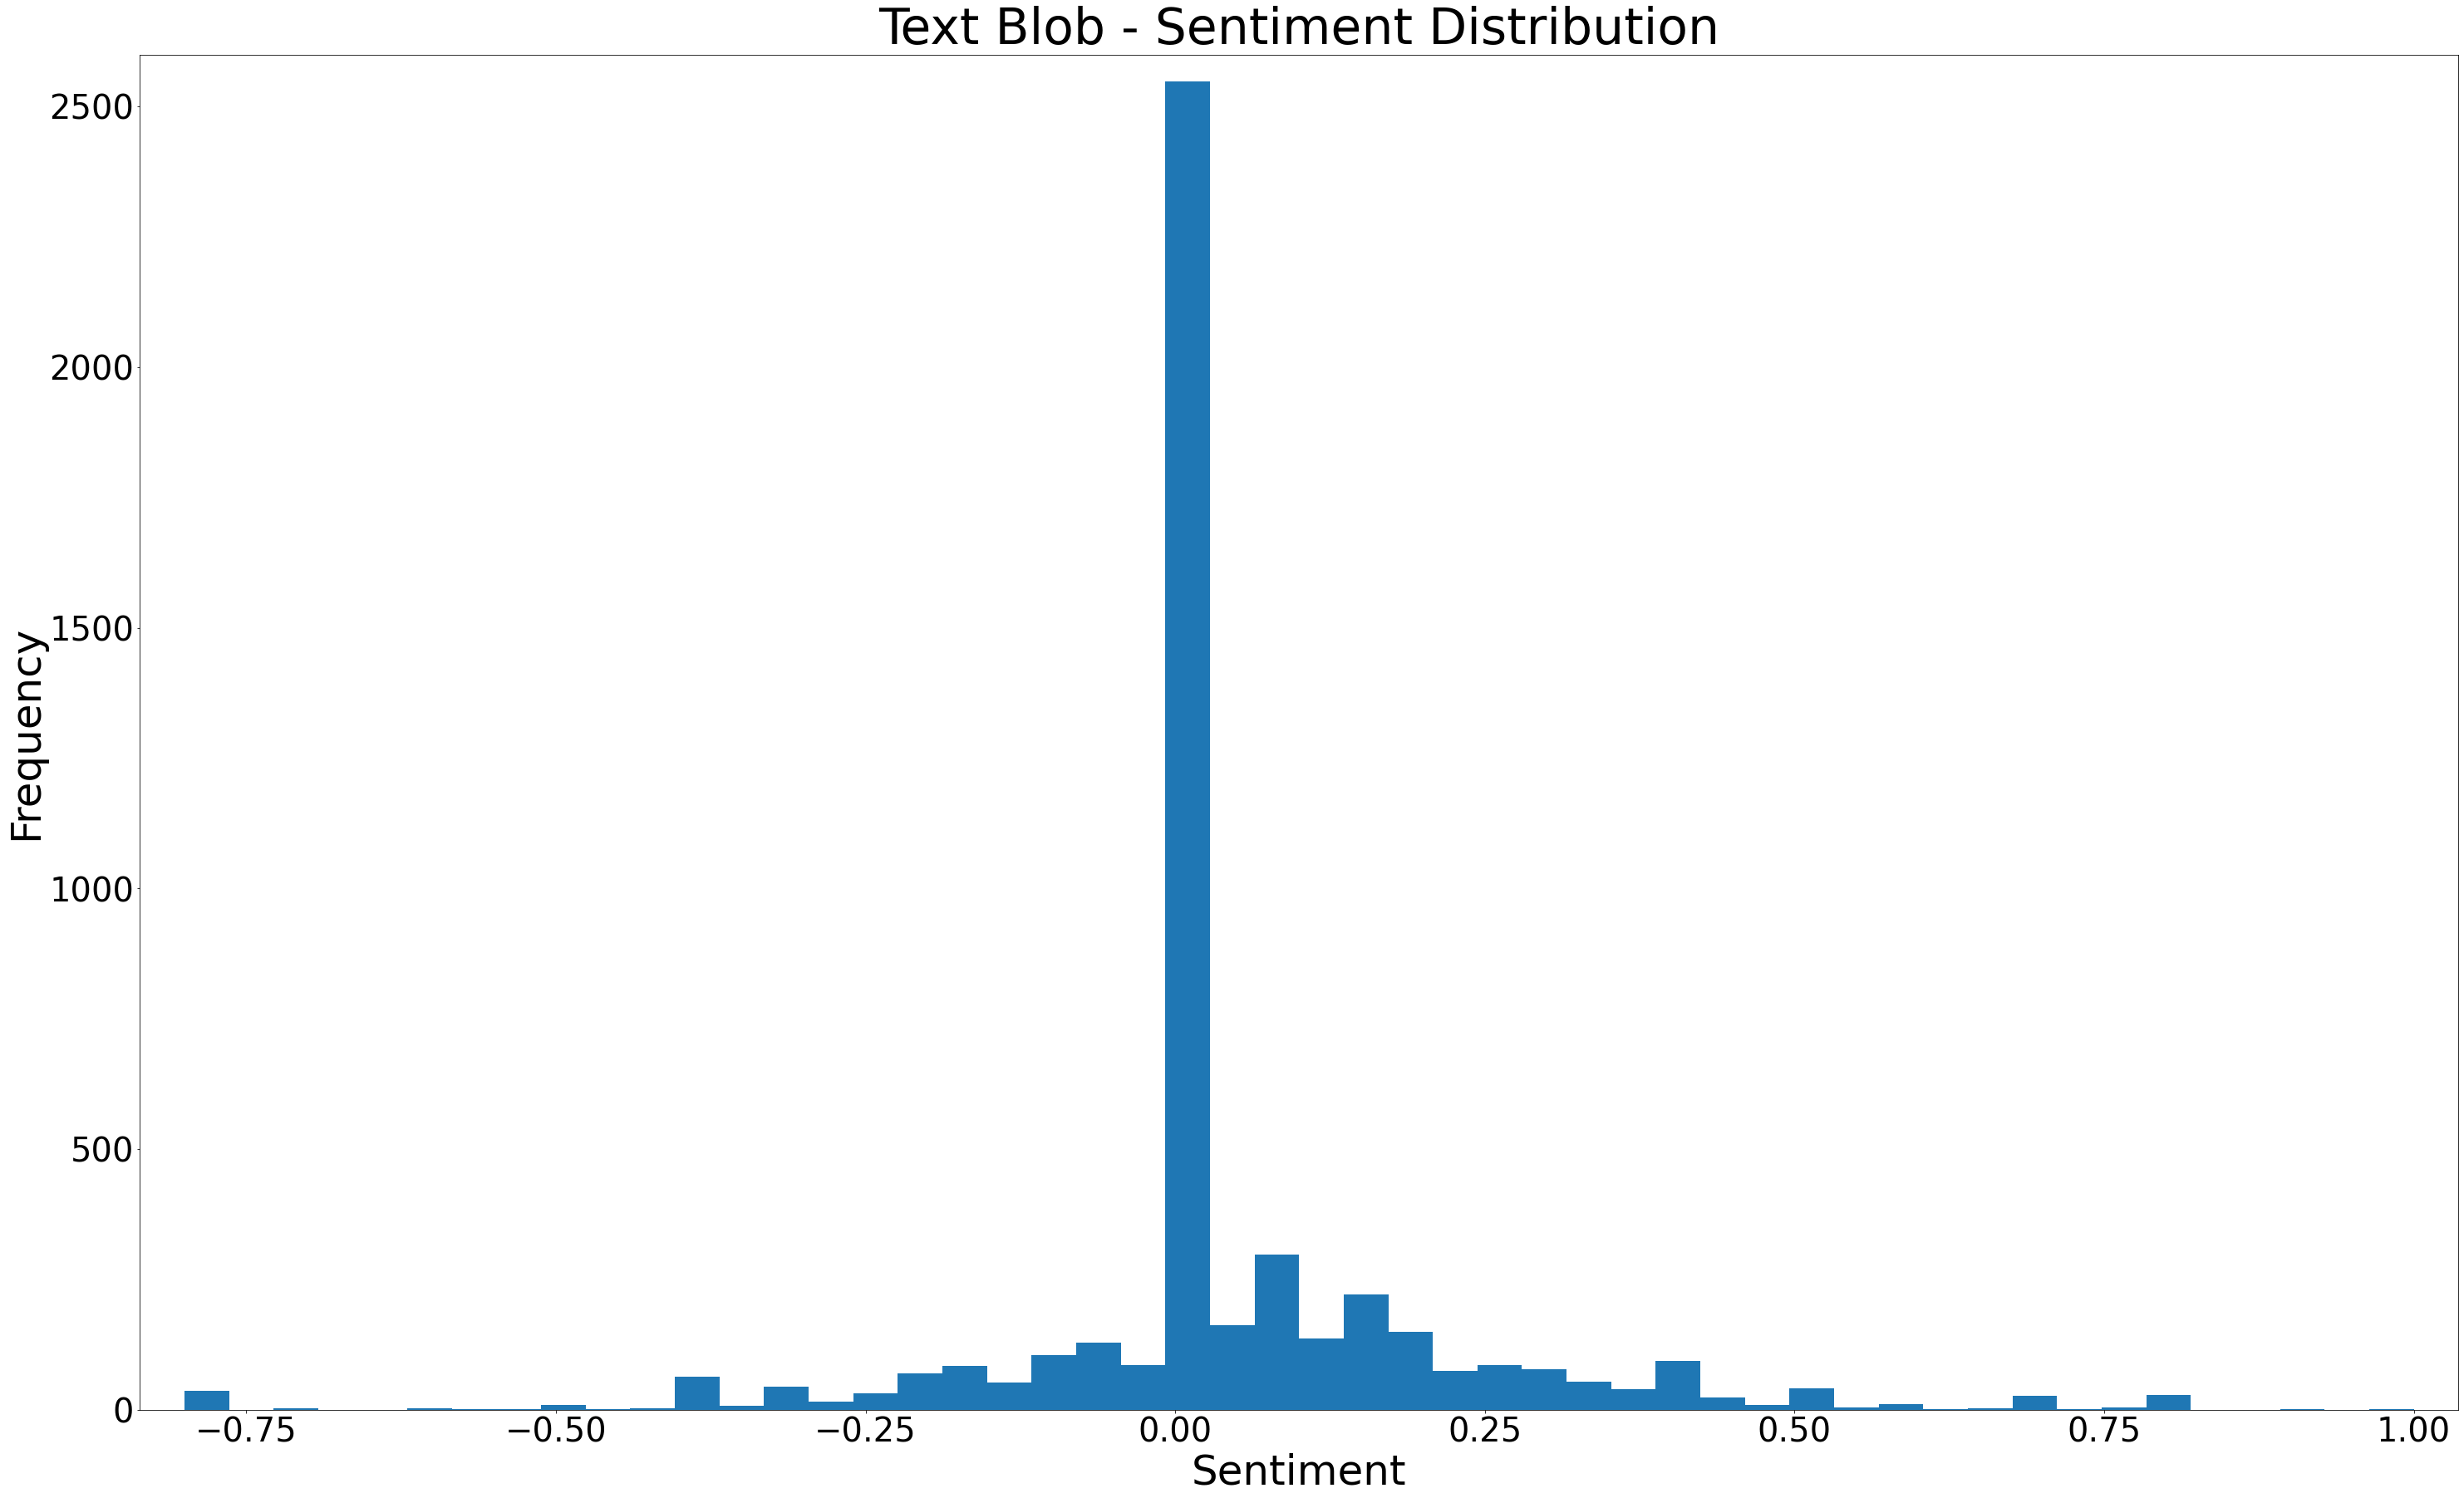

In [17]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Text Blob - Sentiment Distribution', fontsize=60)
plt.show()

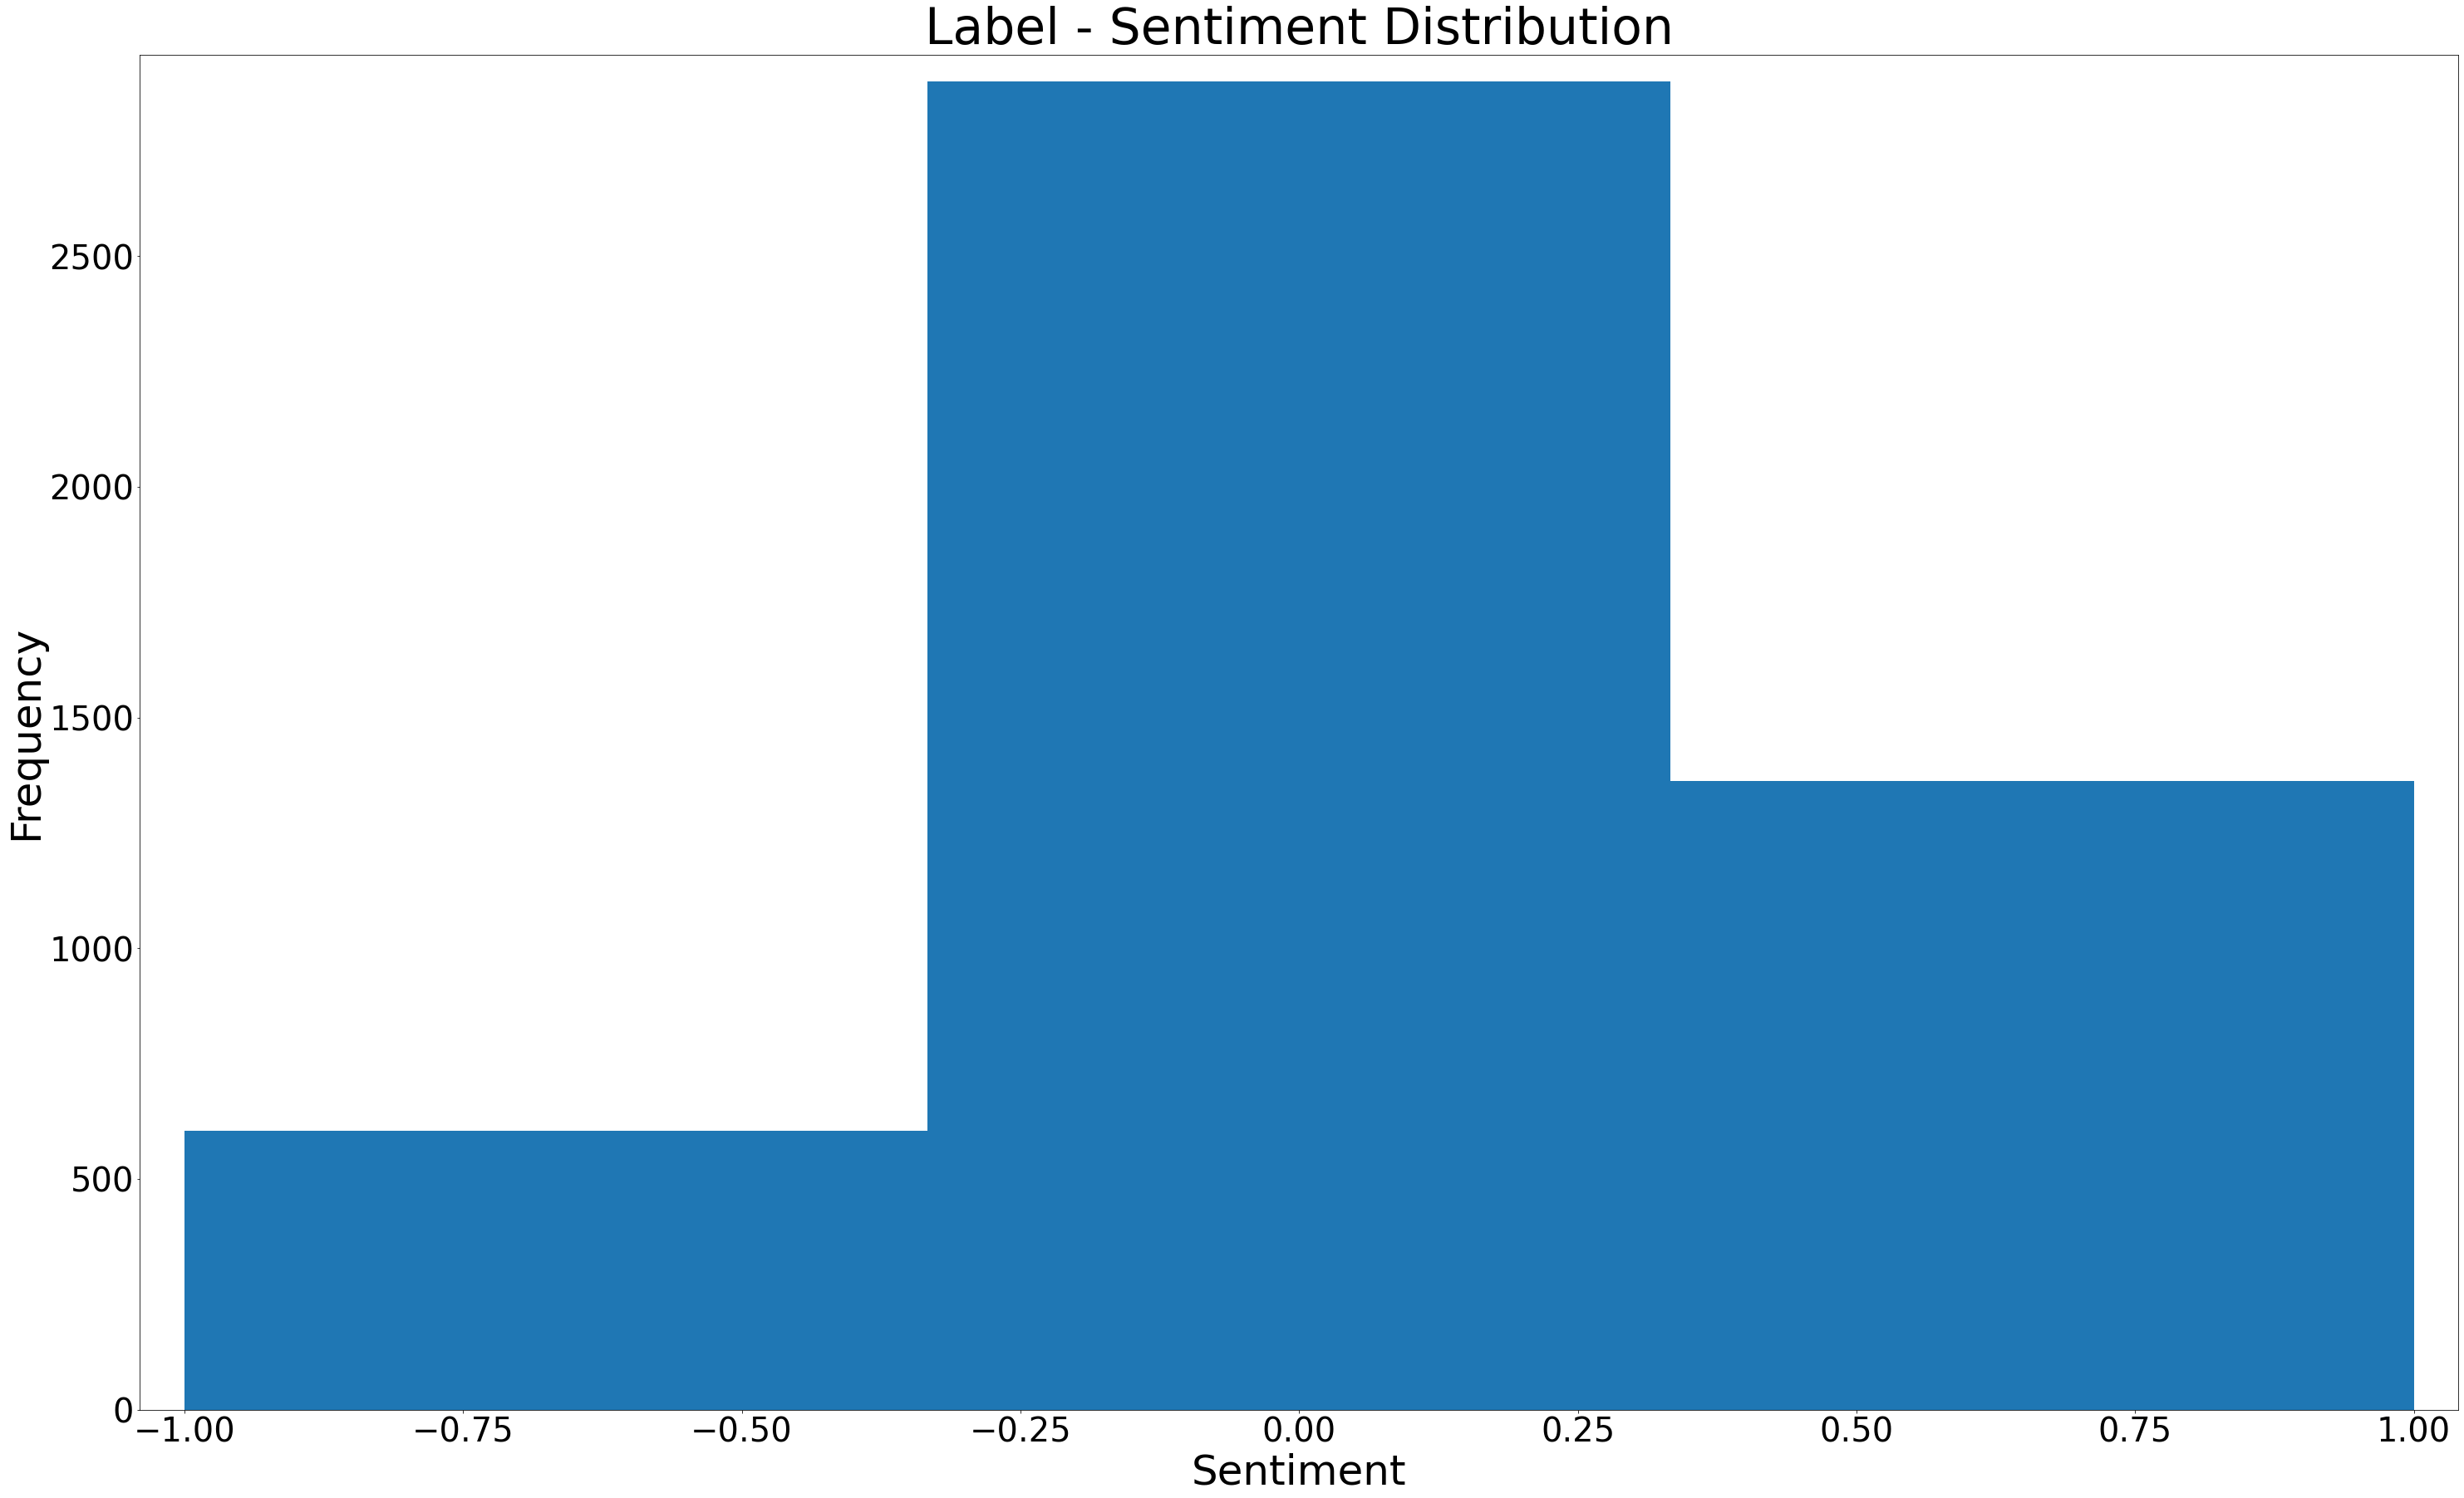

In [18]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['labels'], bins=3)
plt.title('Label - Sentiment Distribution', fontsize=60)
plt.show()

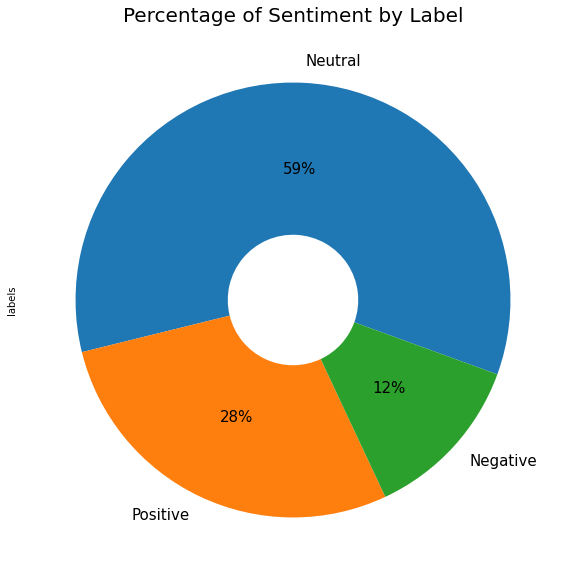

In [22]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Sentiment by Label', fontsize=20)
df.labels.value_counts().plot(kind='pie', labels = ['Neutral', 'Positive', 'Negative'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.show()

In [23]:
#### 
df['word_count'] = df['messages'].apply(lambda x: len(str(x).split()))
df['title_len'] = df['lemm_text'].astype(str).apply(len)

In [25]:
df.head(2)

,labels,messages,lemm_text,sentiment,word_count,title_len
0,0,"[accord, gran, company, no, plan, move, production, russia, although, company, grow]","accord, gran, company, no, plan, move, production, russia, although, company, grow",0.000000,21,82
1,0,"[technopoli, plan, develop, stage, area, no, less, square, meter, order, host, compan...","technopoli, plan, develop, stage, area, no, less, square, meter, order, host, company, work, com...",0.083333,33,129


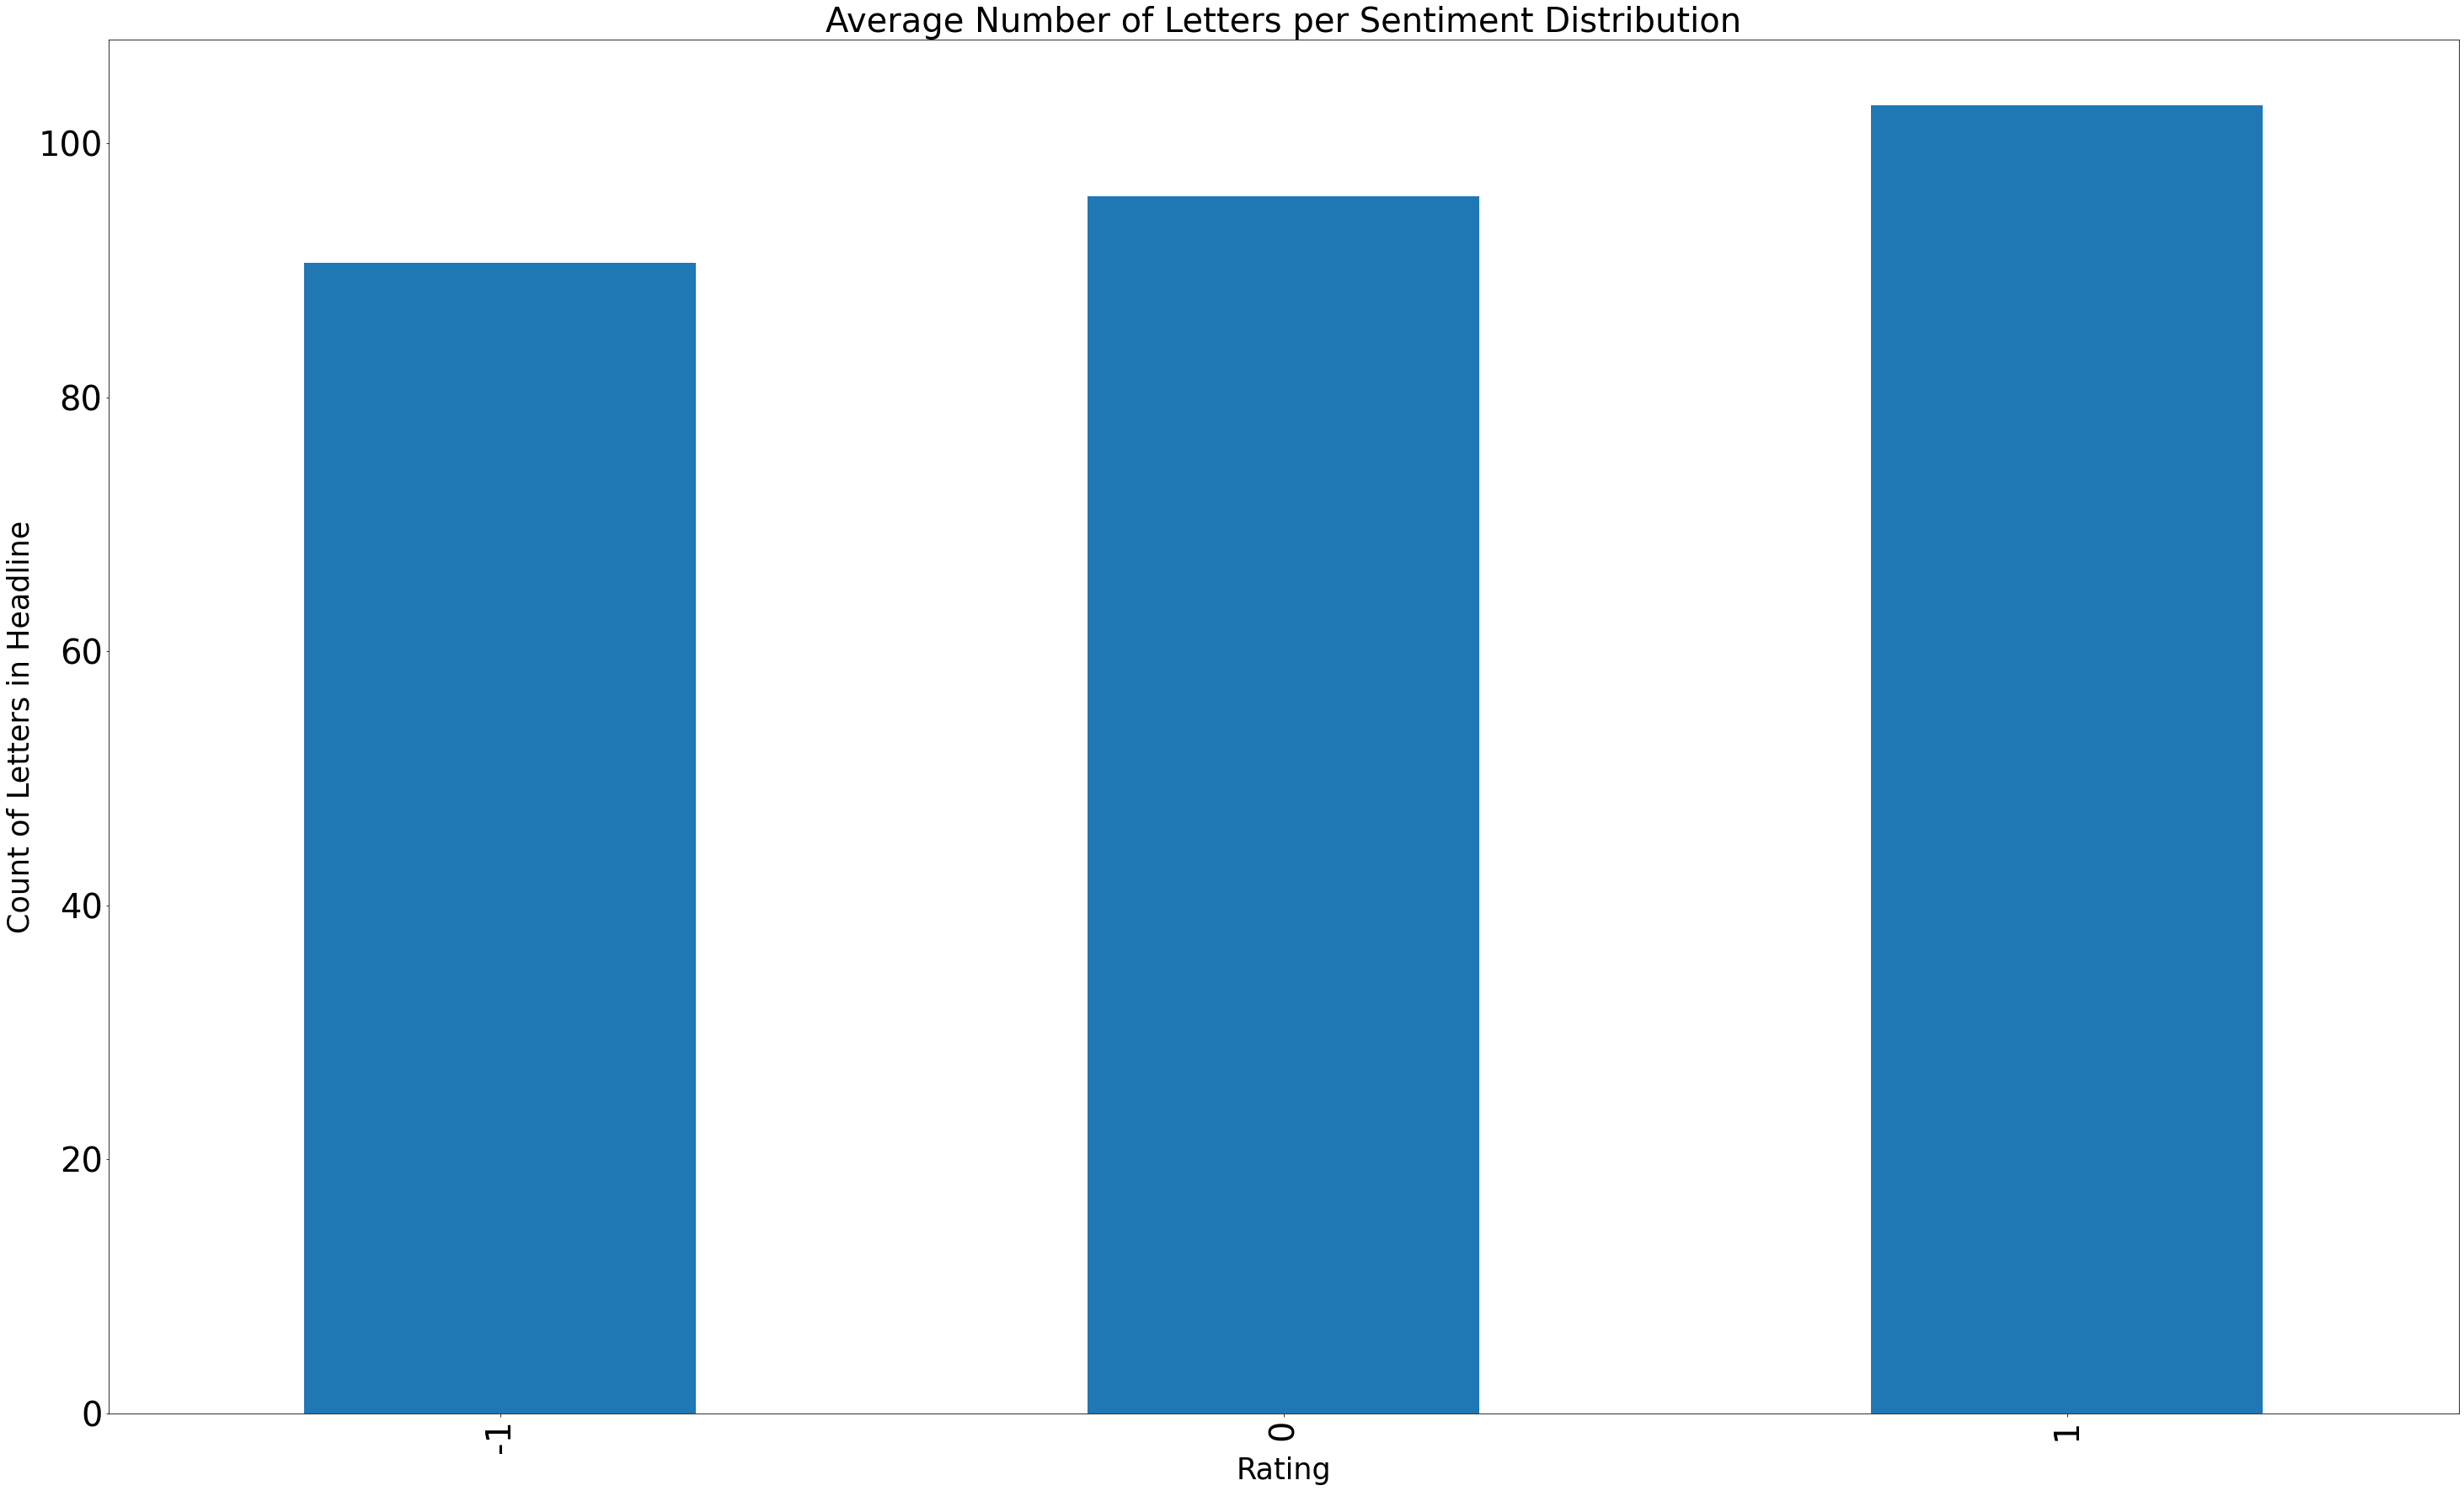

In [29]:
letter_avg = df.groupby('labels')['title_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Headline', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Sentiment Distribution', fontsize=40)
plt.show()

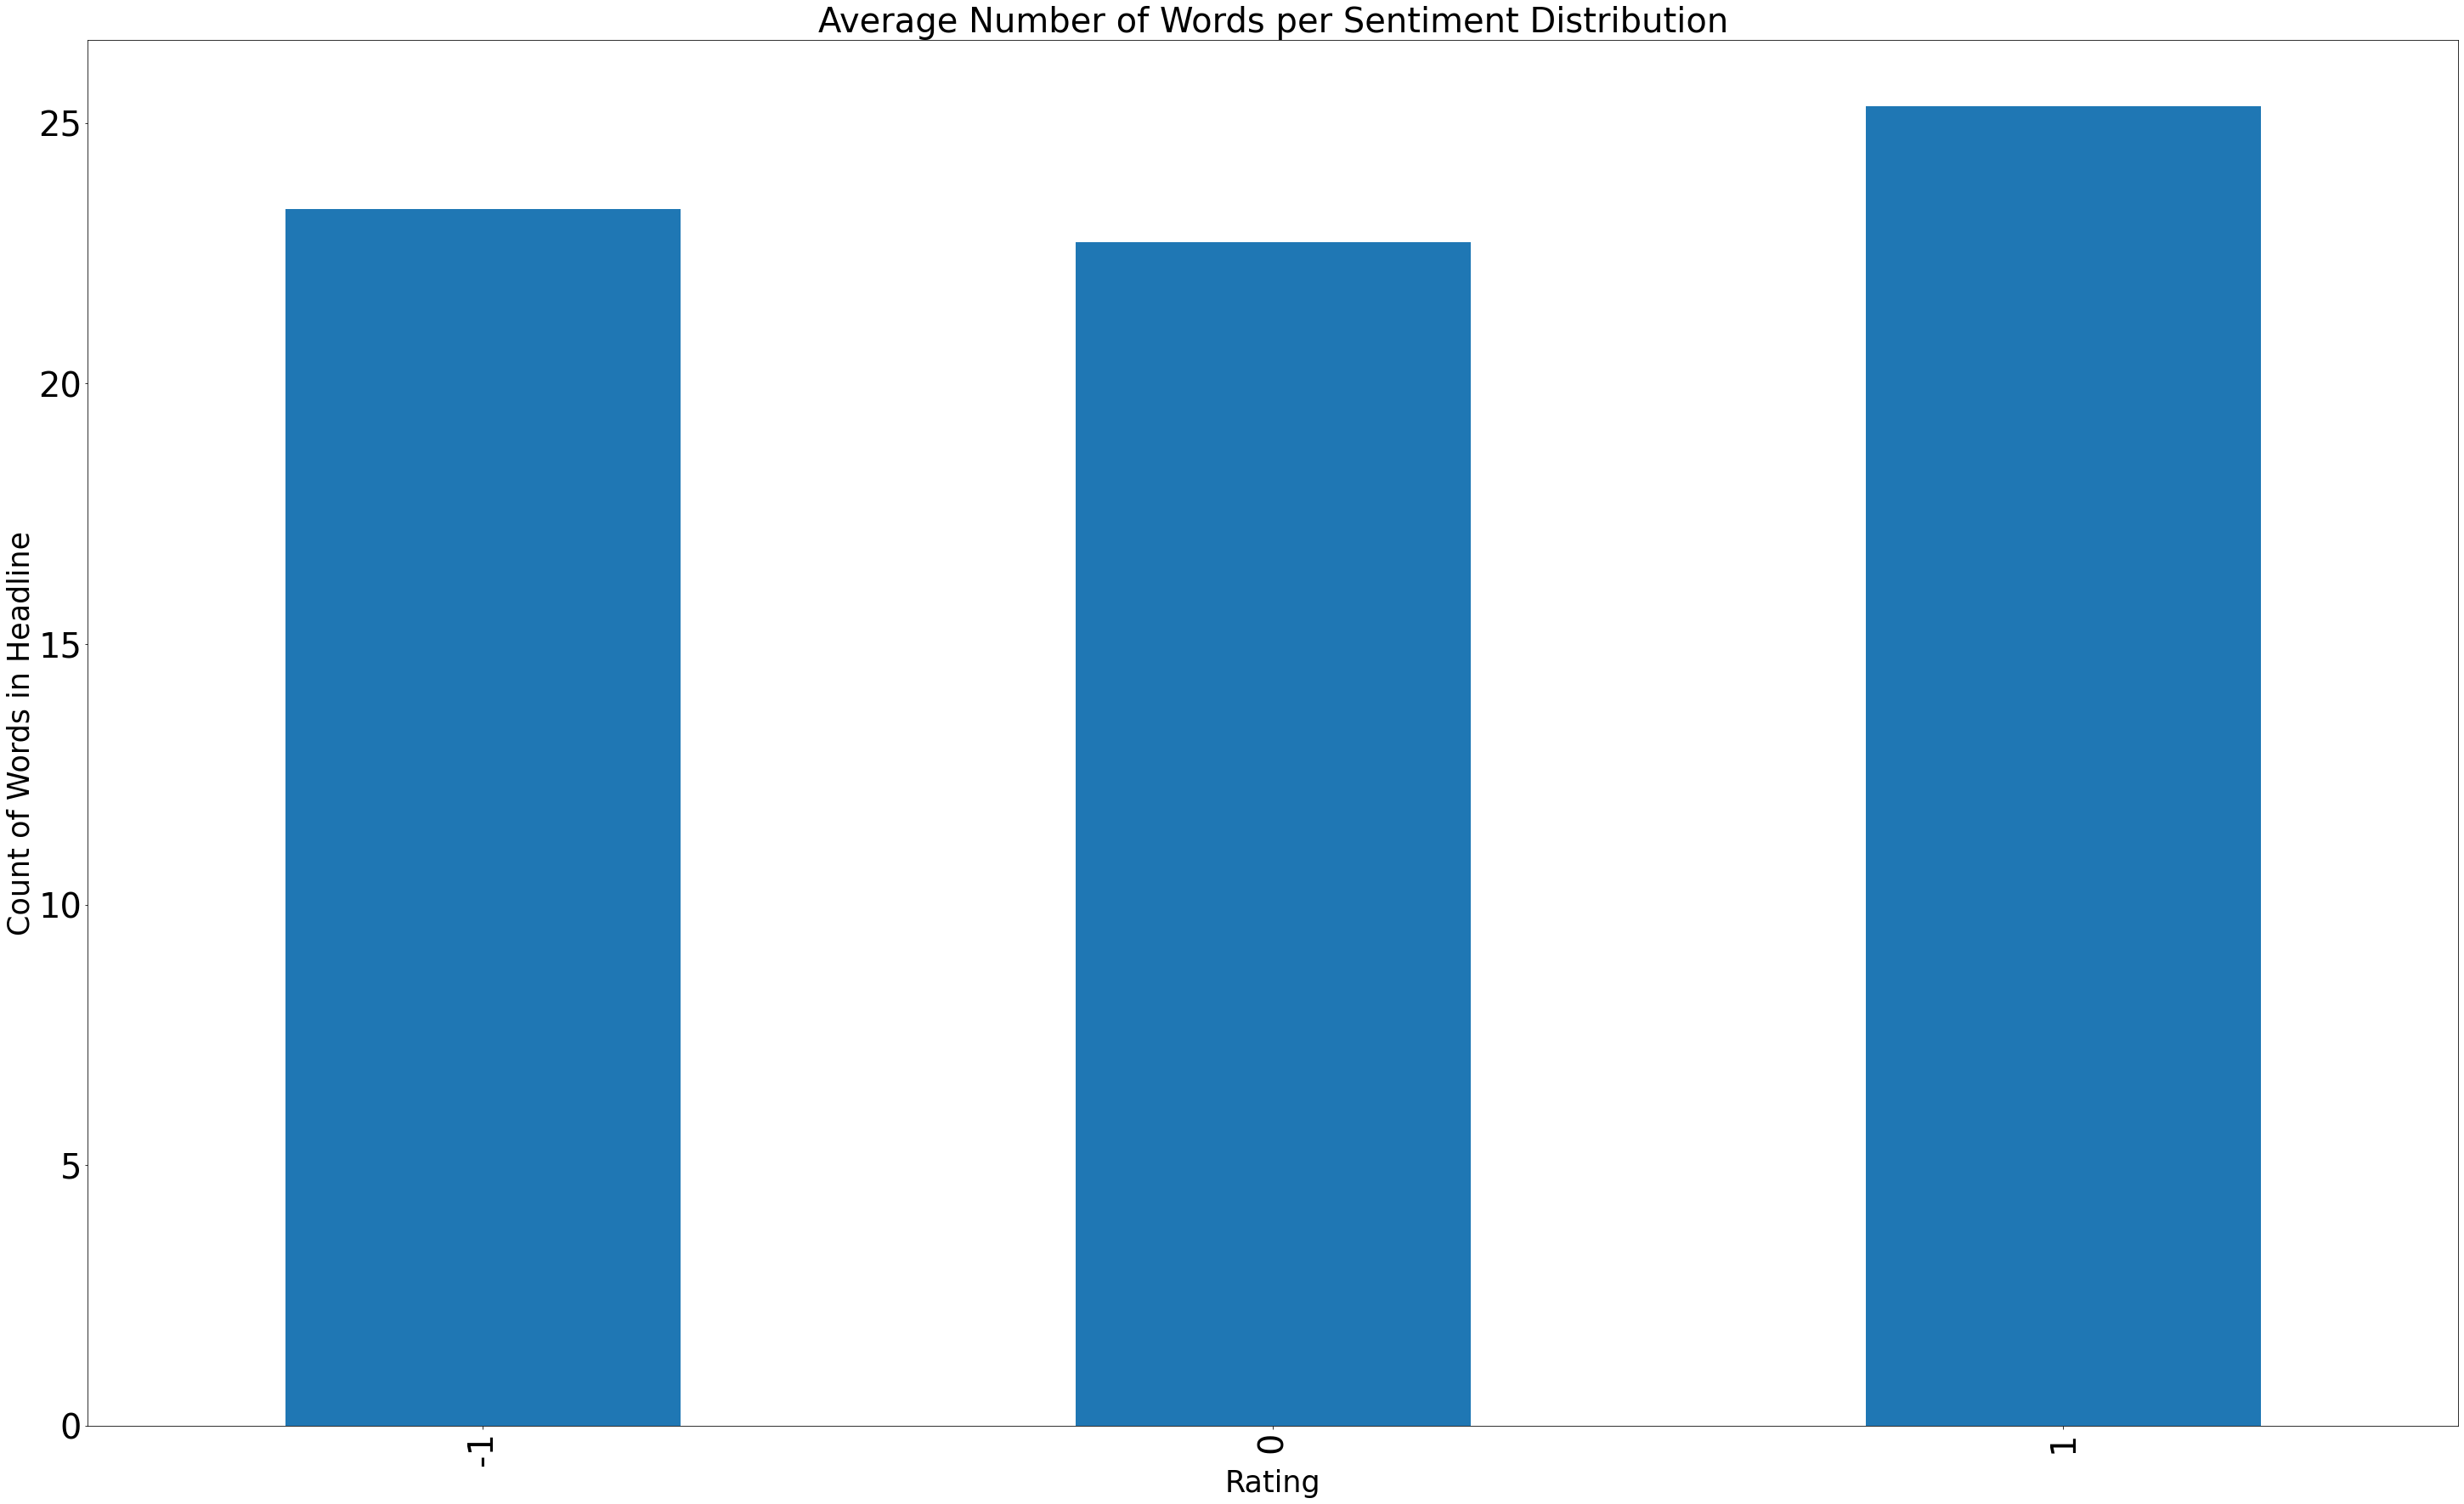

In [30]:
word_avg = df.groupby('labels')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Headline', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Sentiment Distribution', fontsize=40)
plt.show()

Both headline length and word count tend to be longer for positive headlines; however, this is only marginally so.

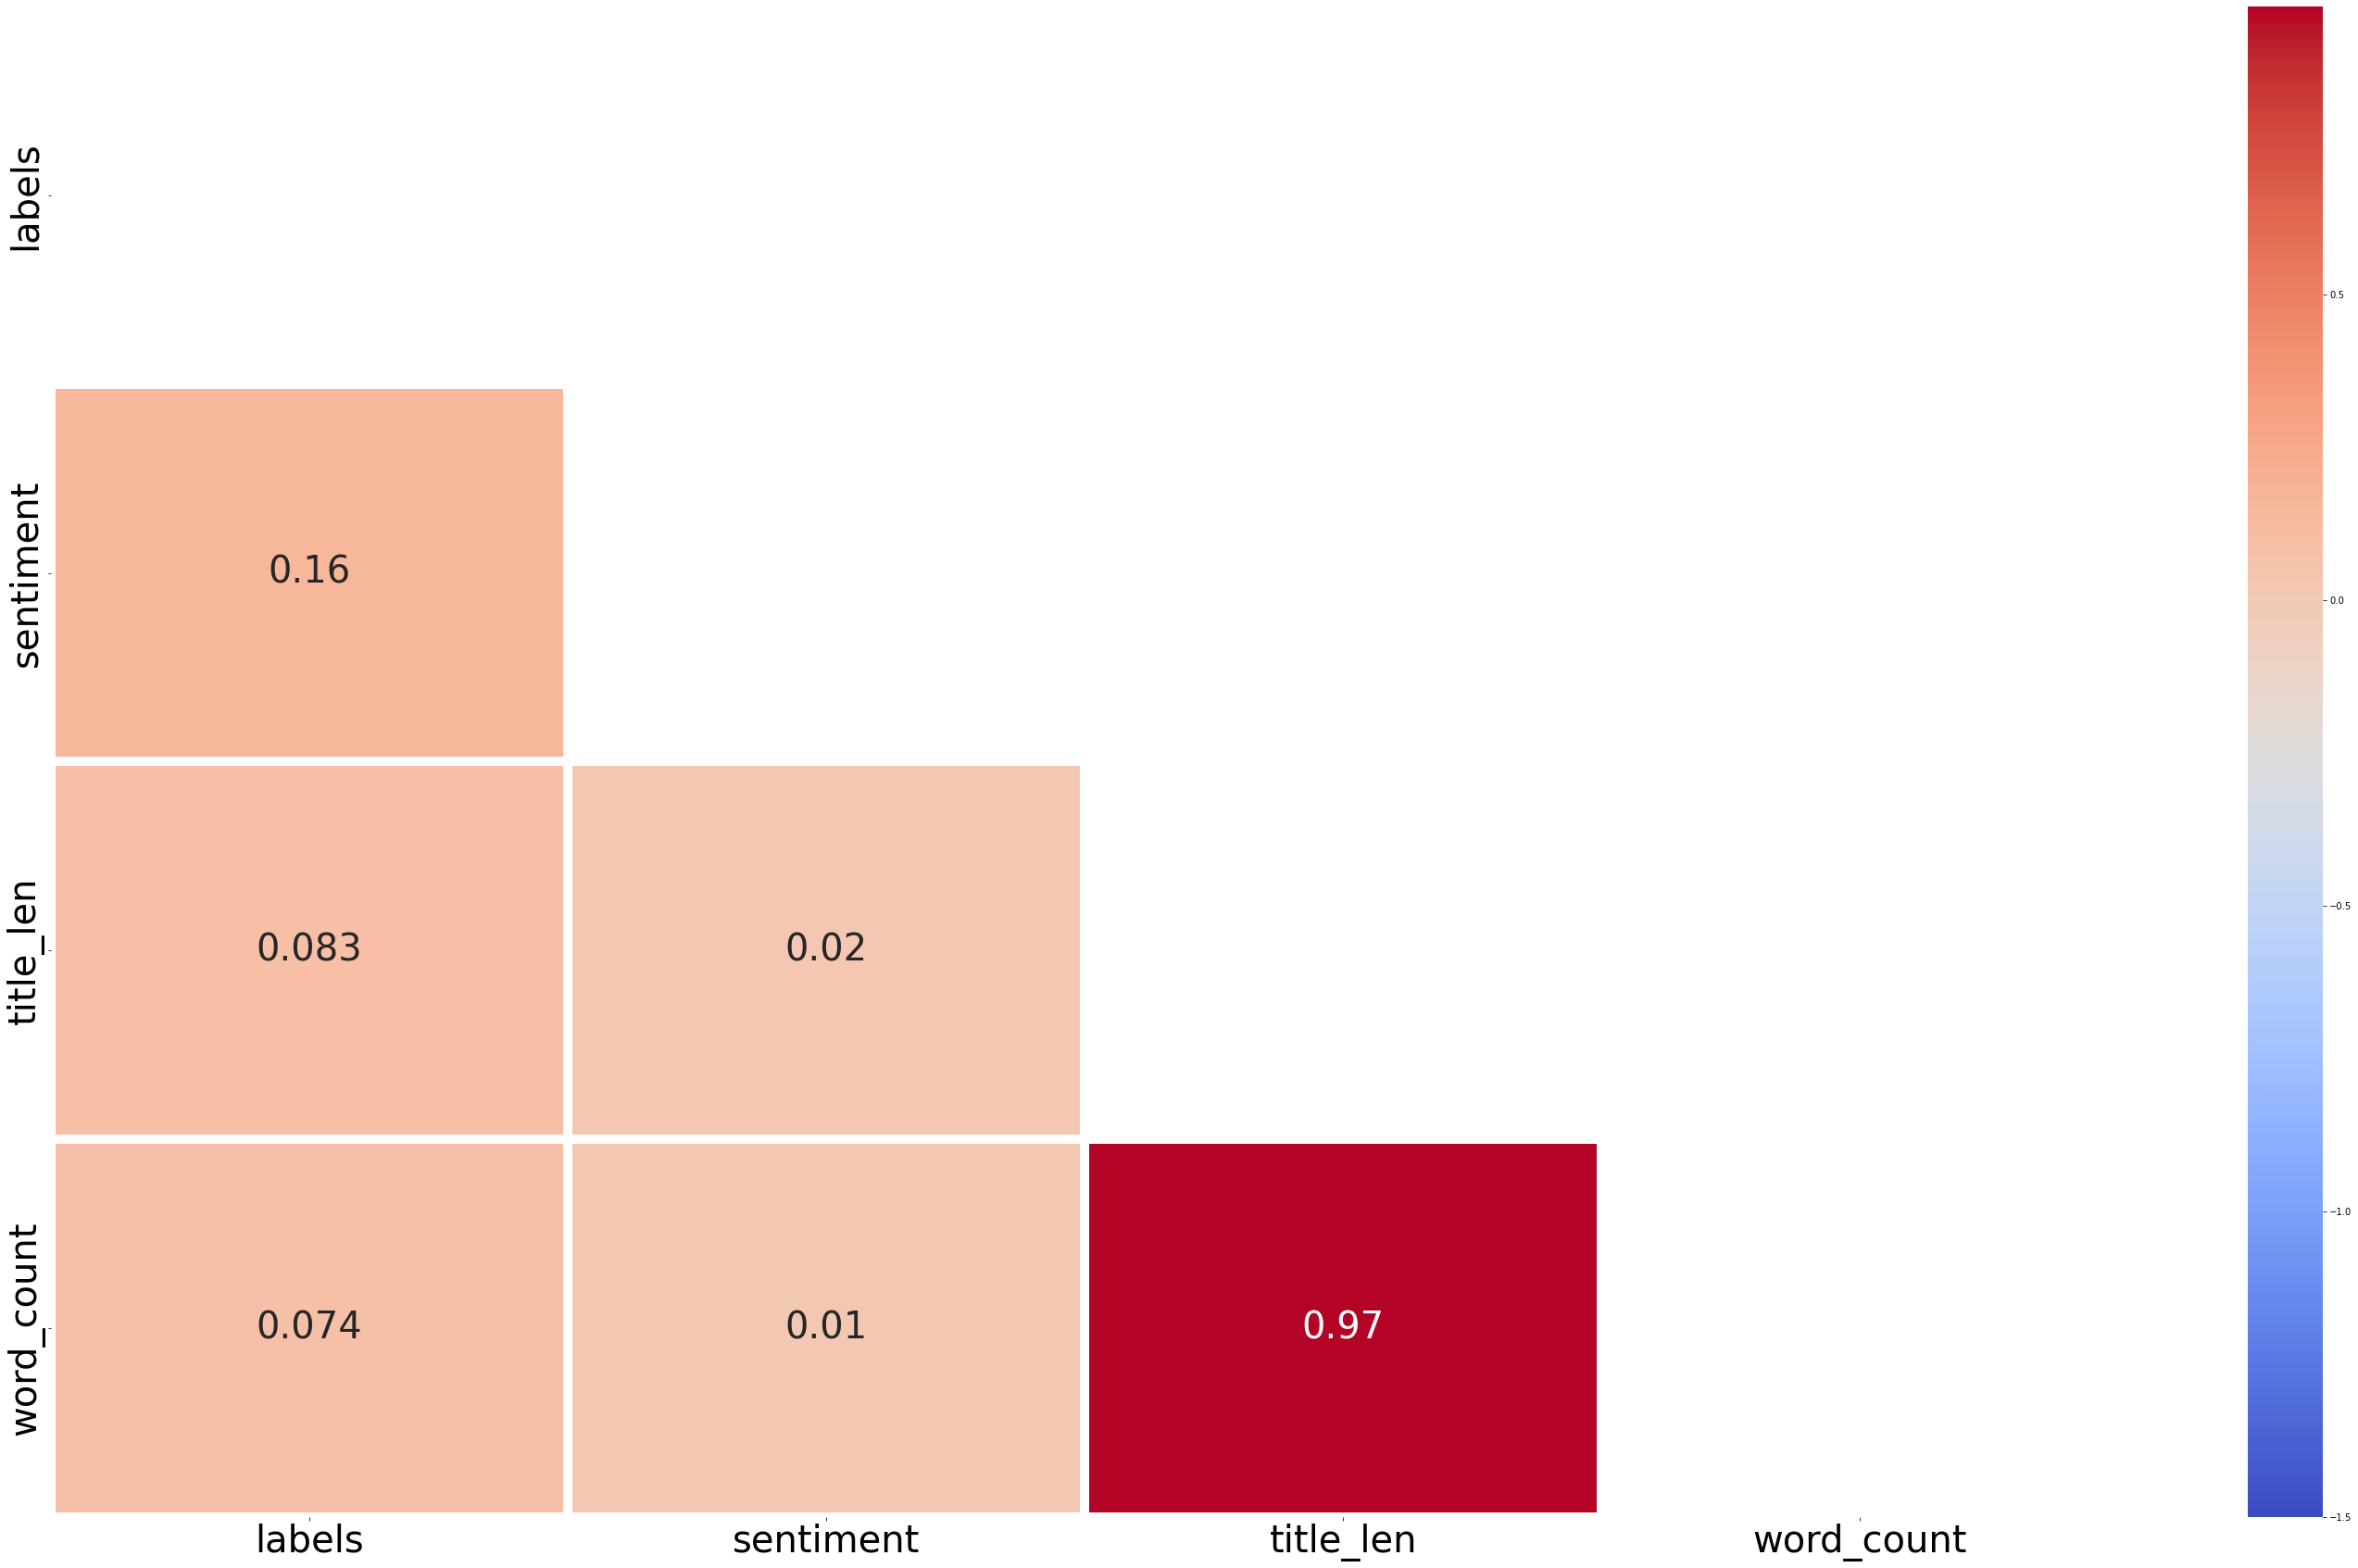

In [33]:
correlation = df[['labels','sentiment', 'title_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)
plt.show()

## Term Frequency Analysis

In [34]:
words = df['messages']
allwords = []
for wordlist in words:
    allwords += wordlist

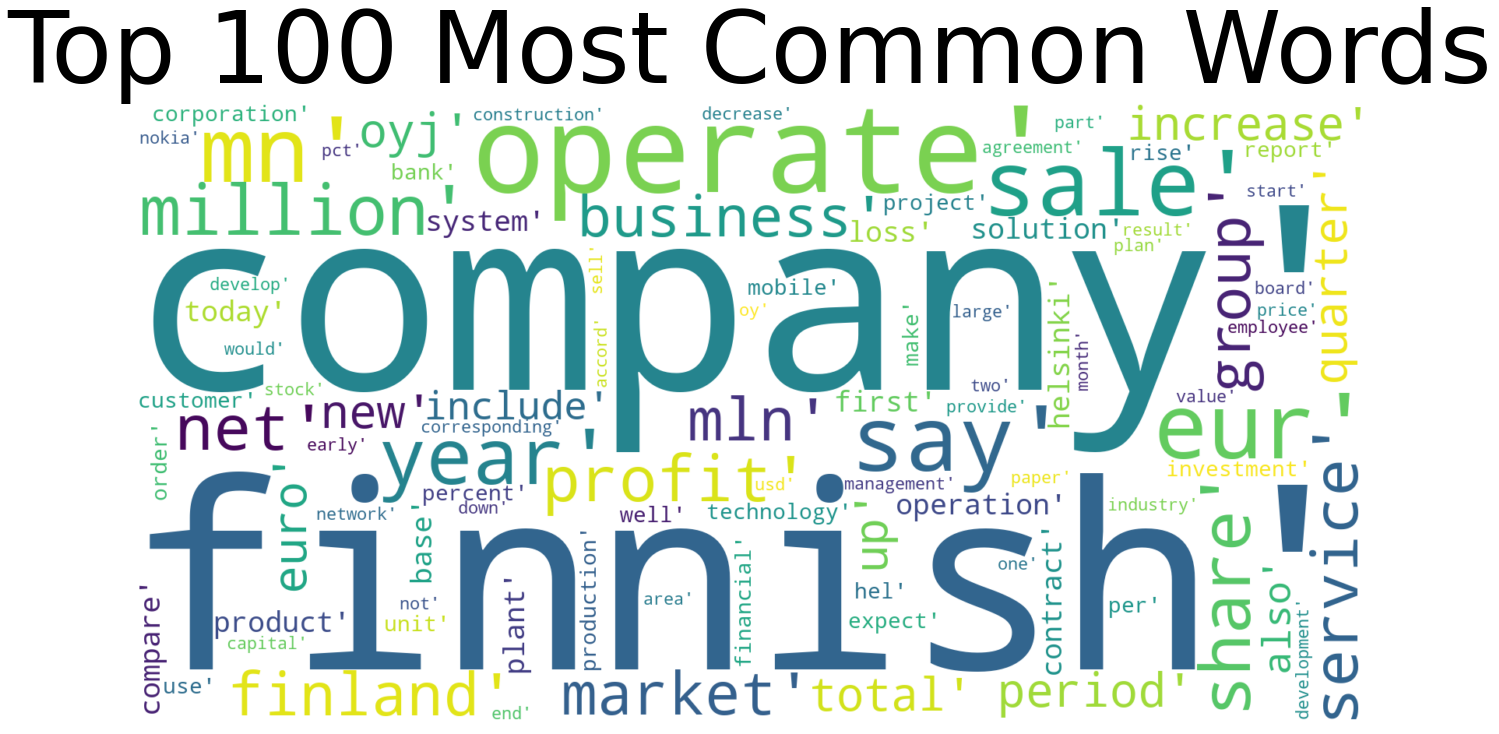

In [35]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

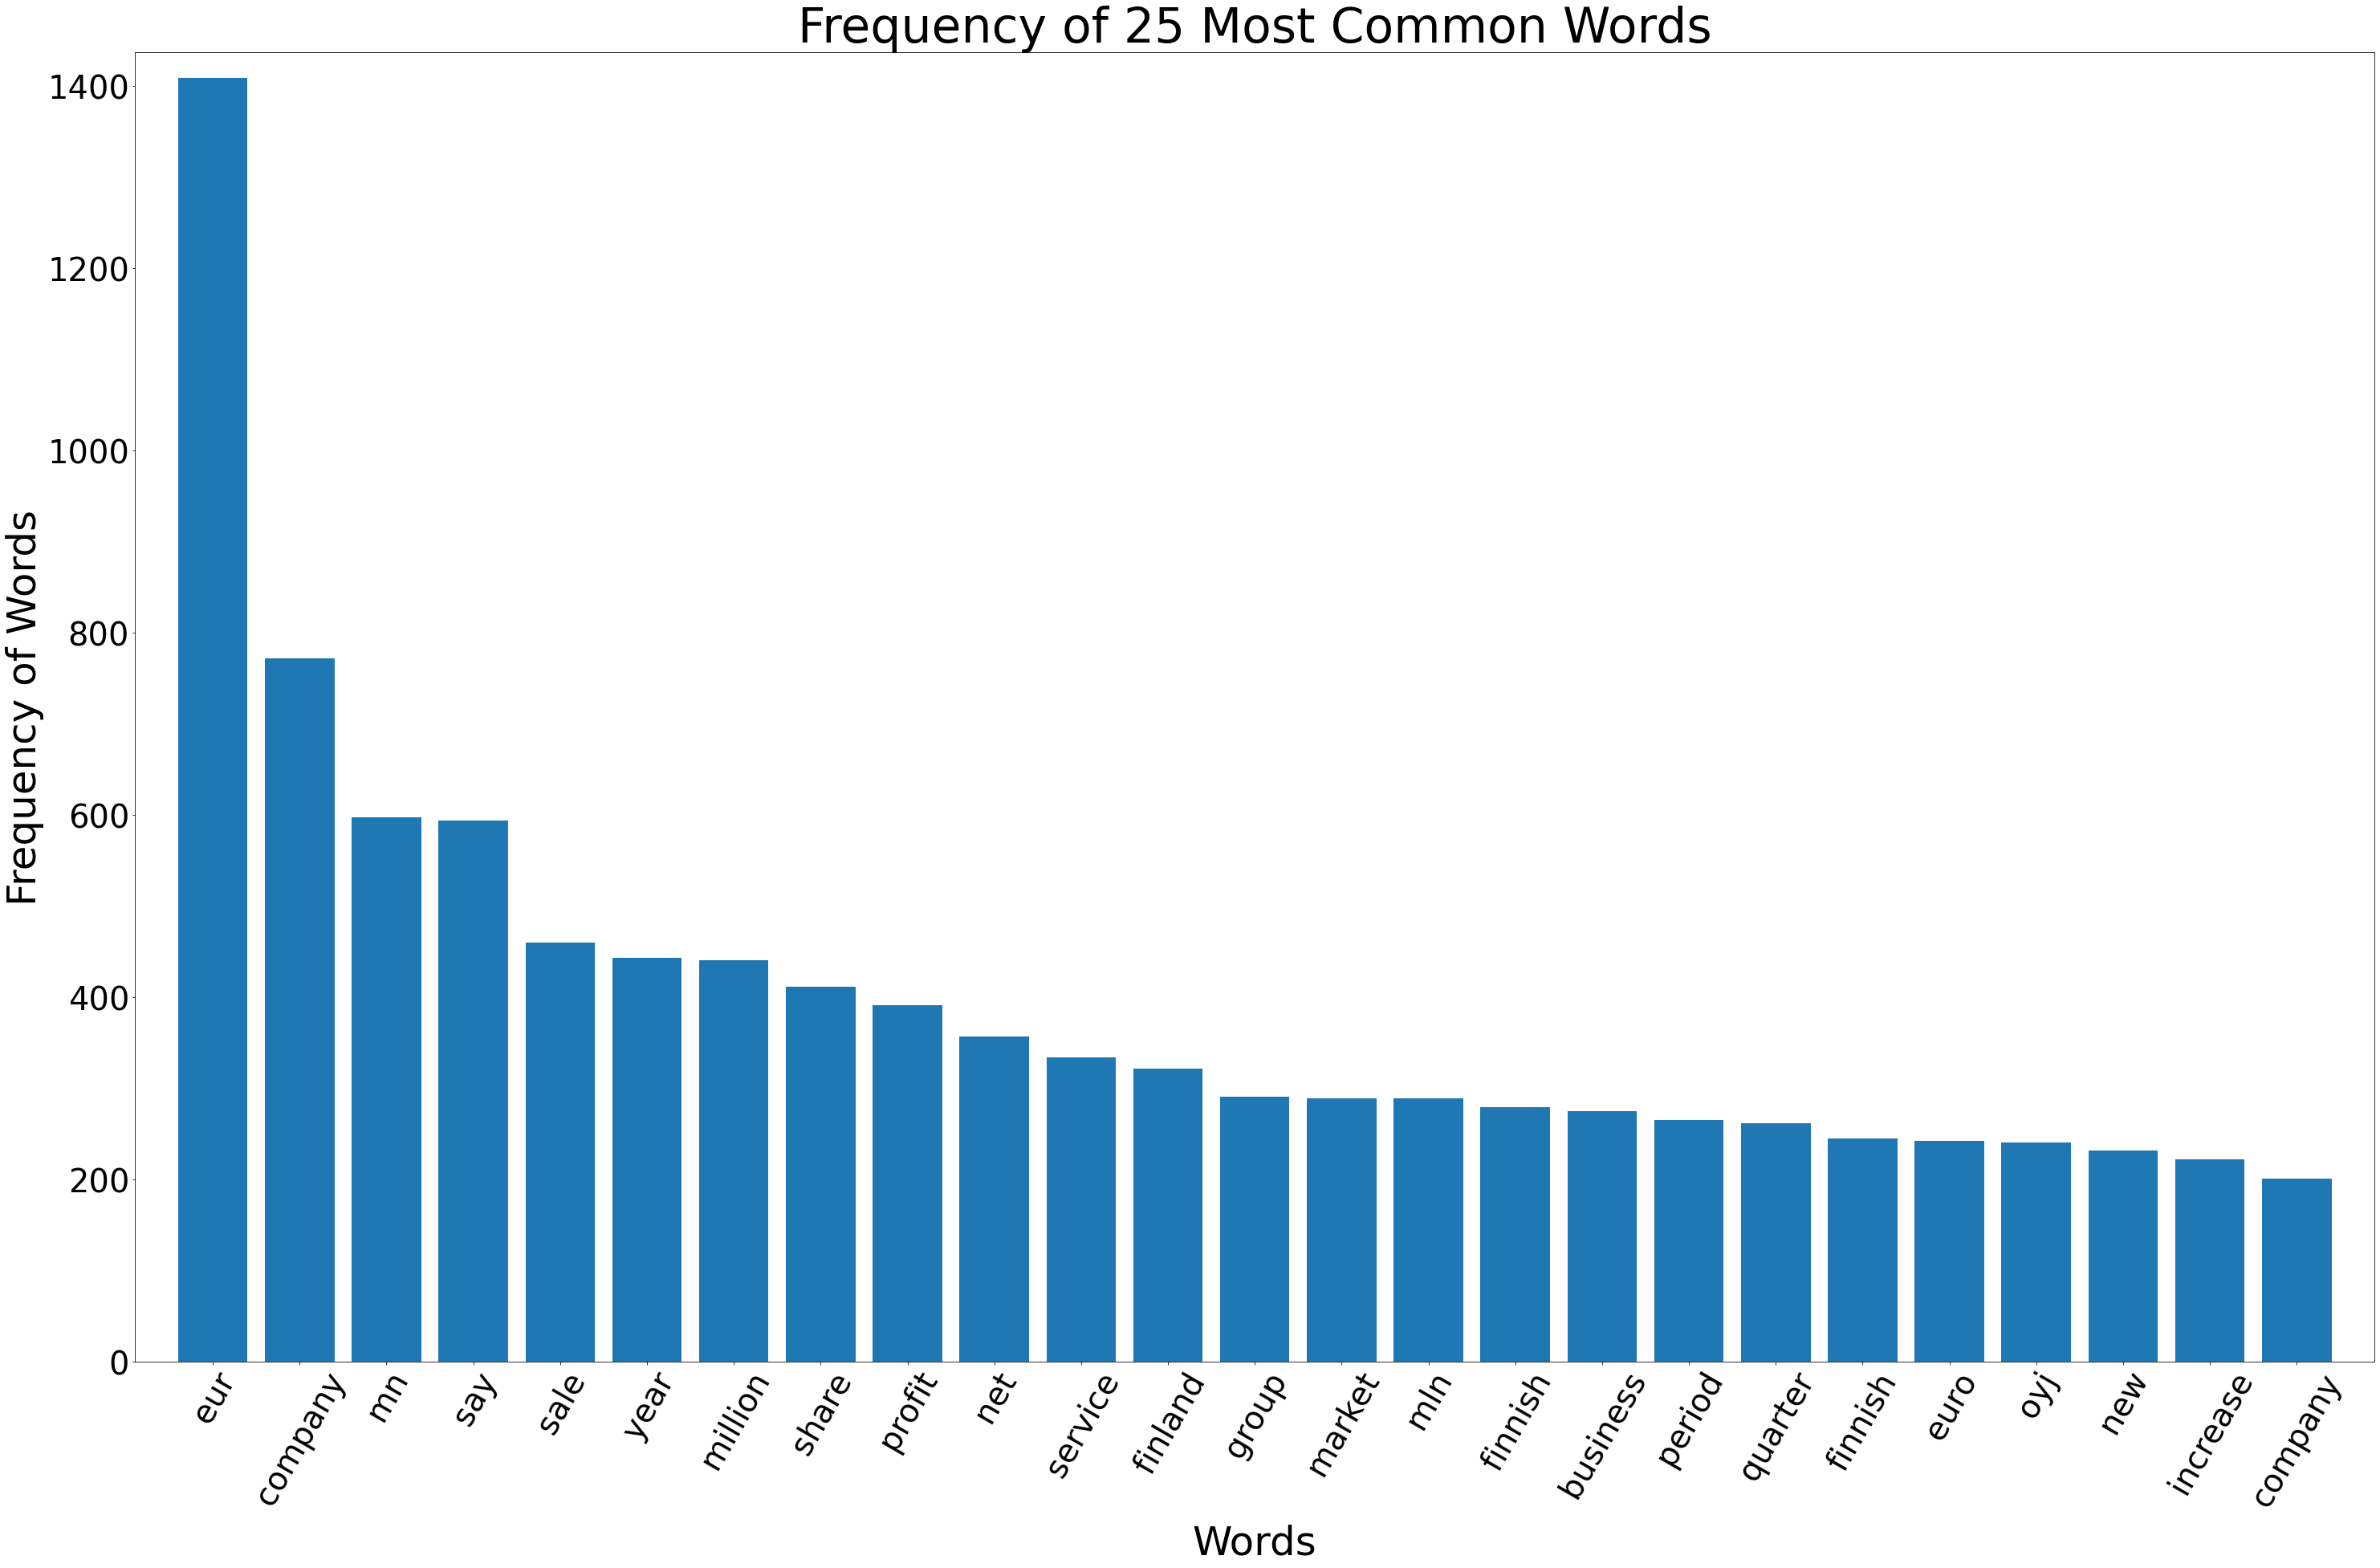

In [36]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [38]:
group_by = df.groupby('labels')['lemm_text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))

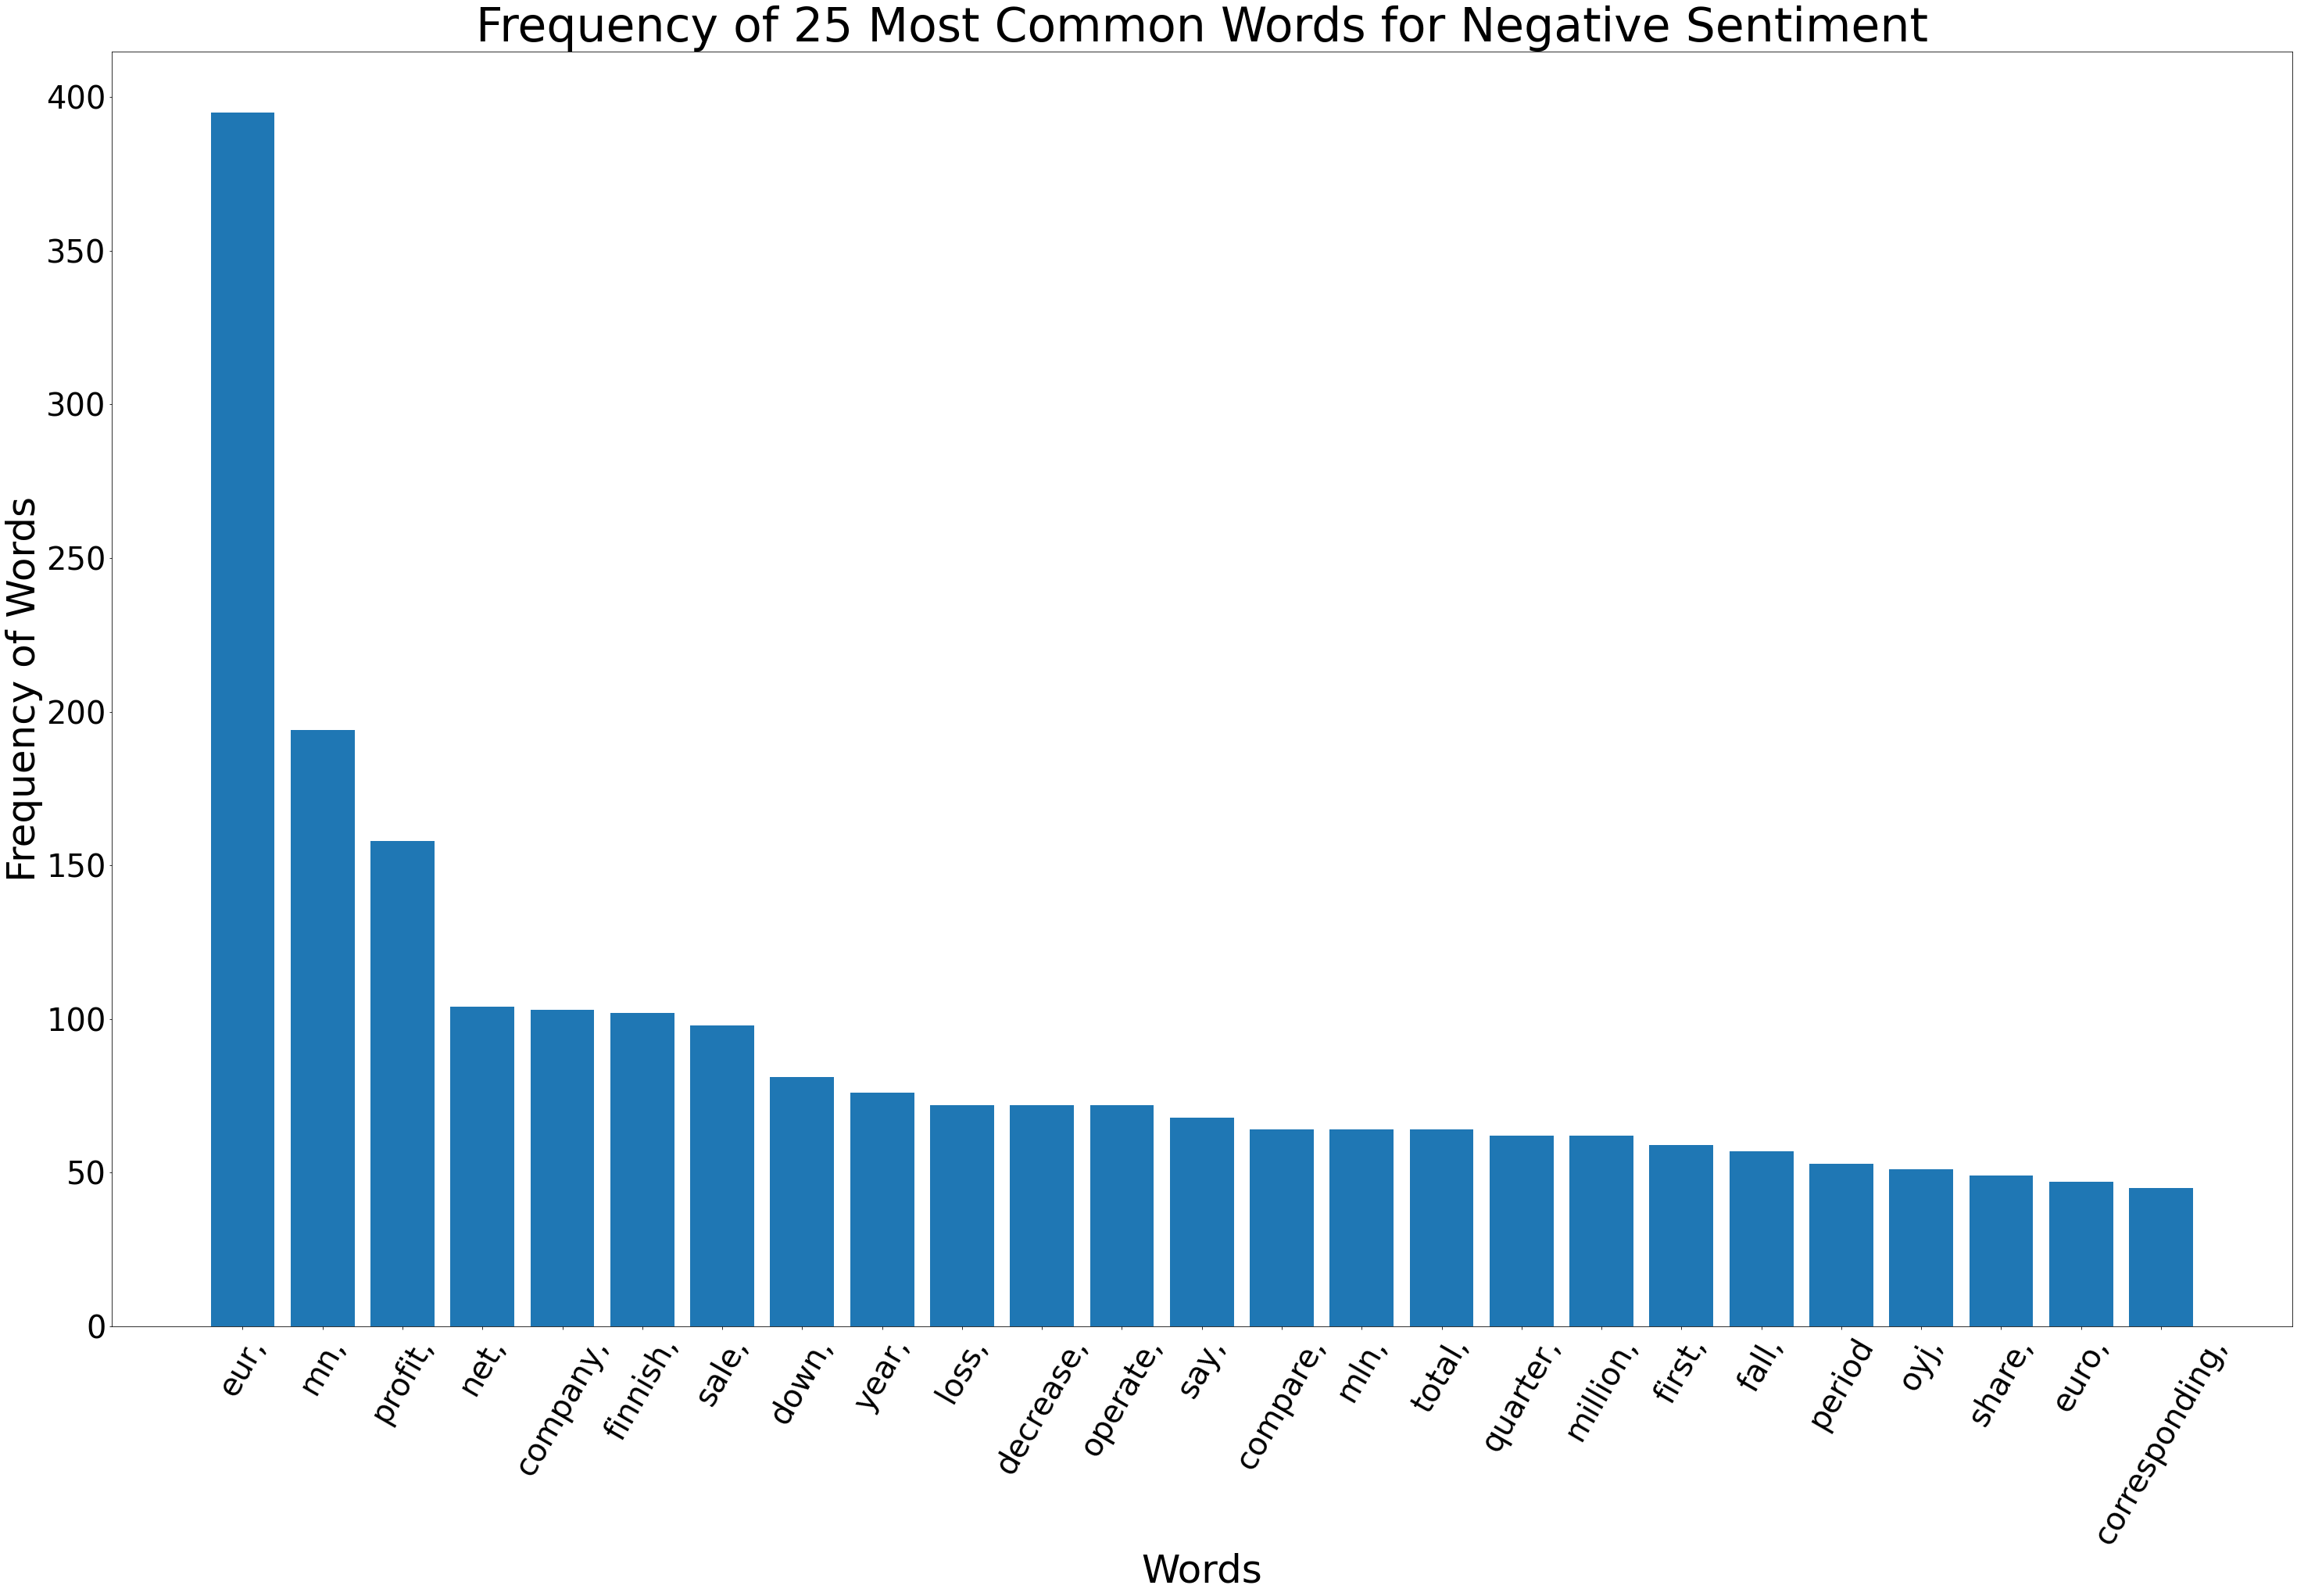

In [44]:
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Negative Sentiment', fontsize=60)
plt.show()

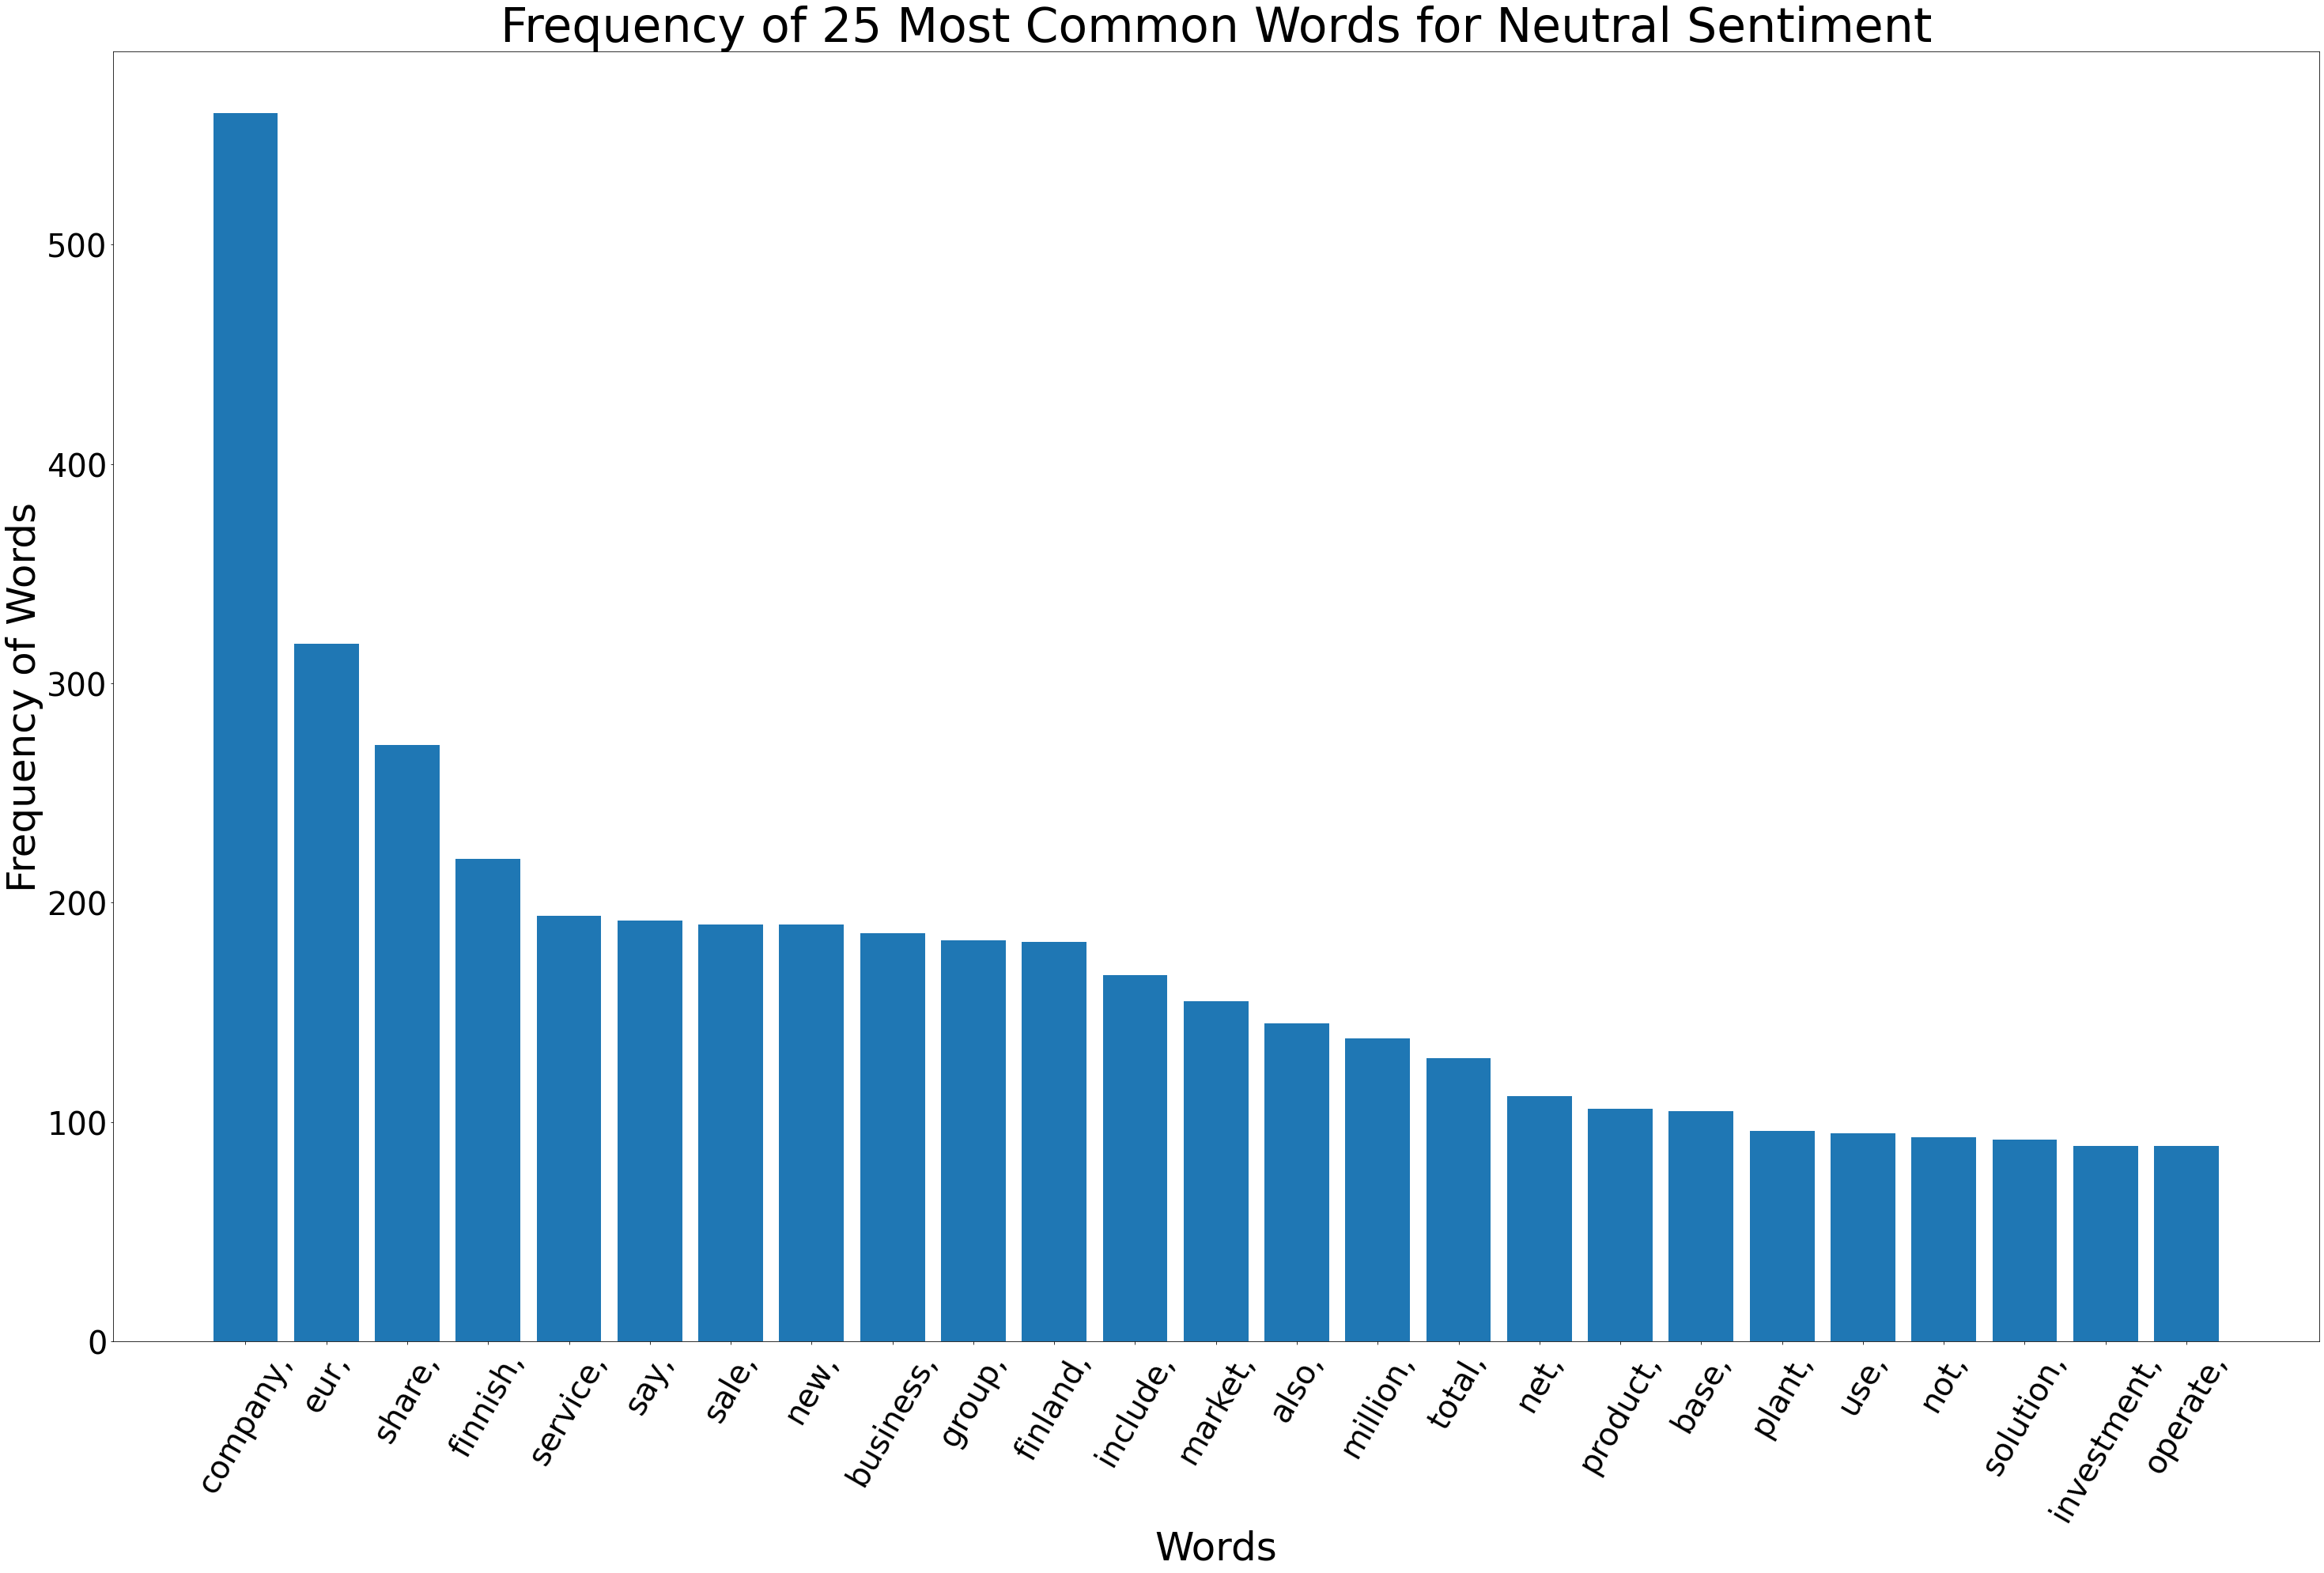

In [45]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Neutral Sentiment', fontsize=60)
plt.show()

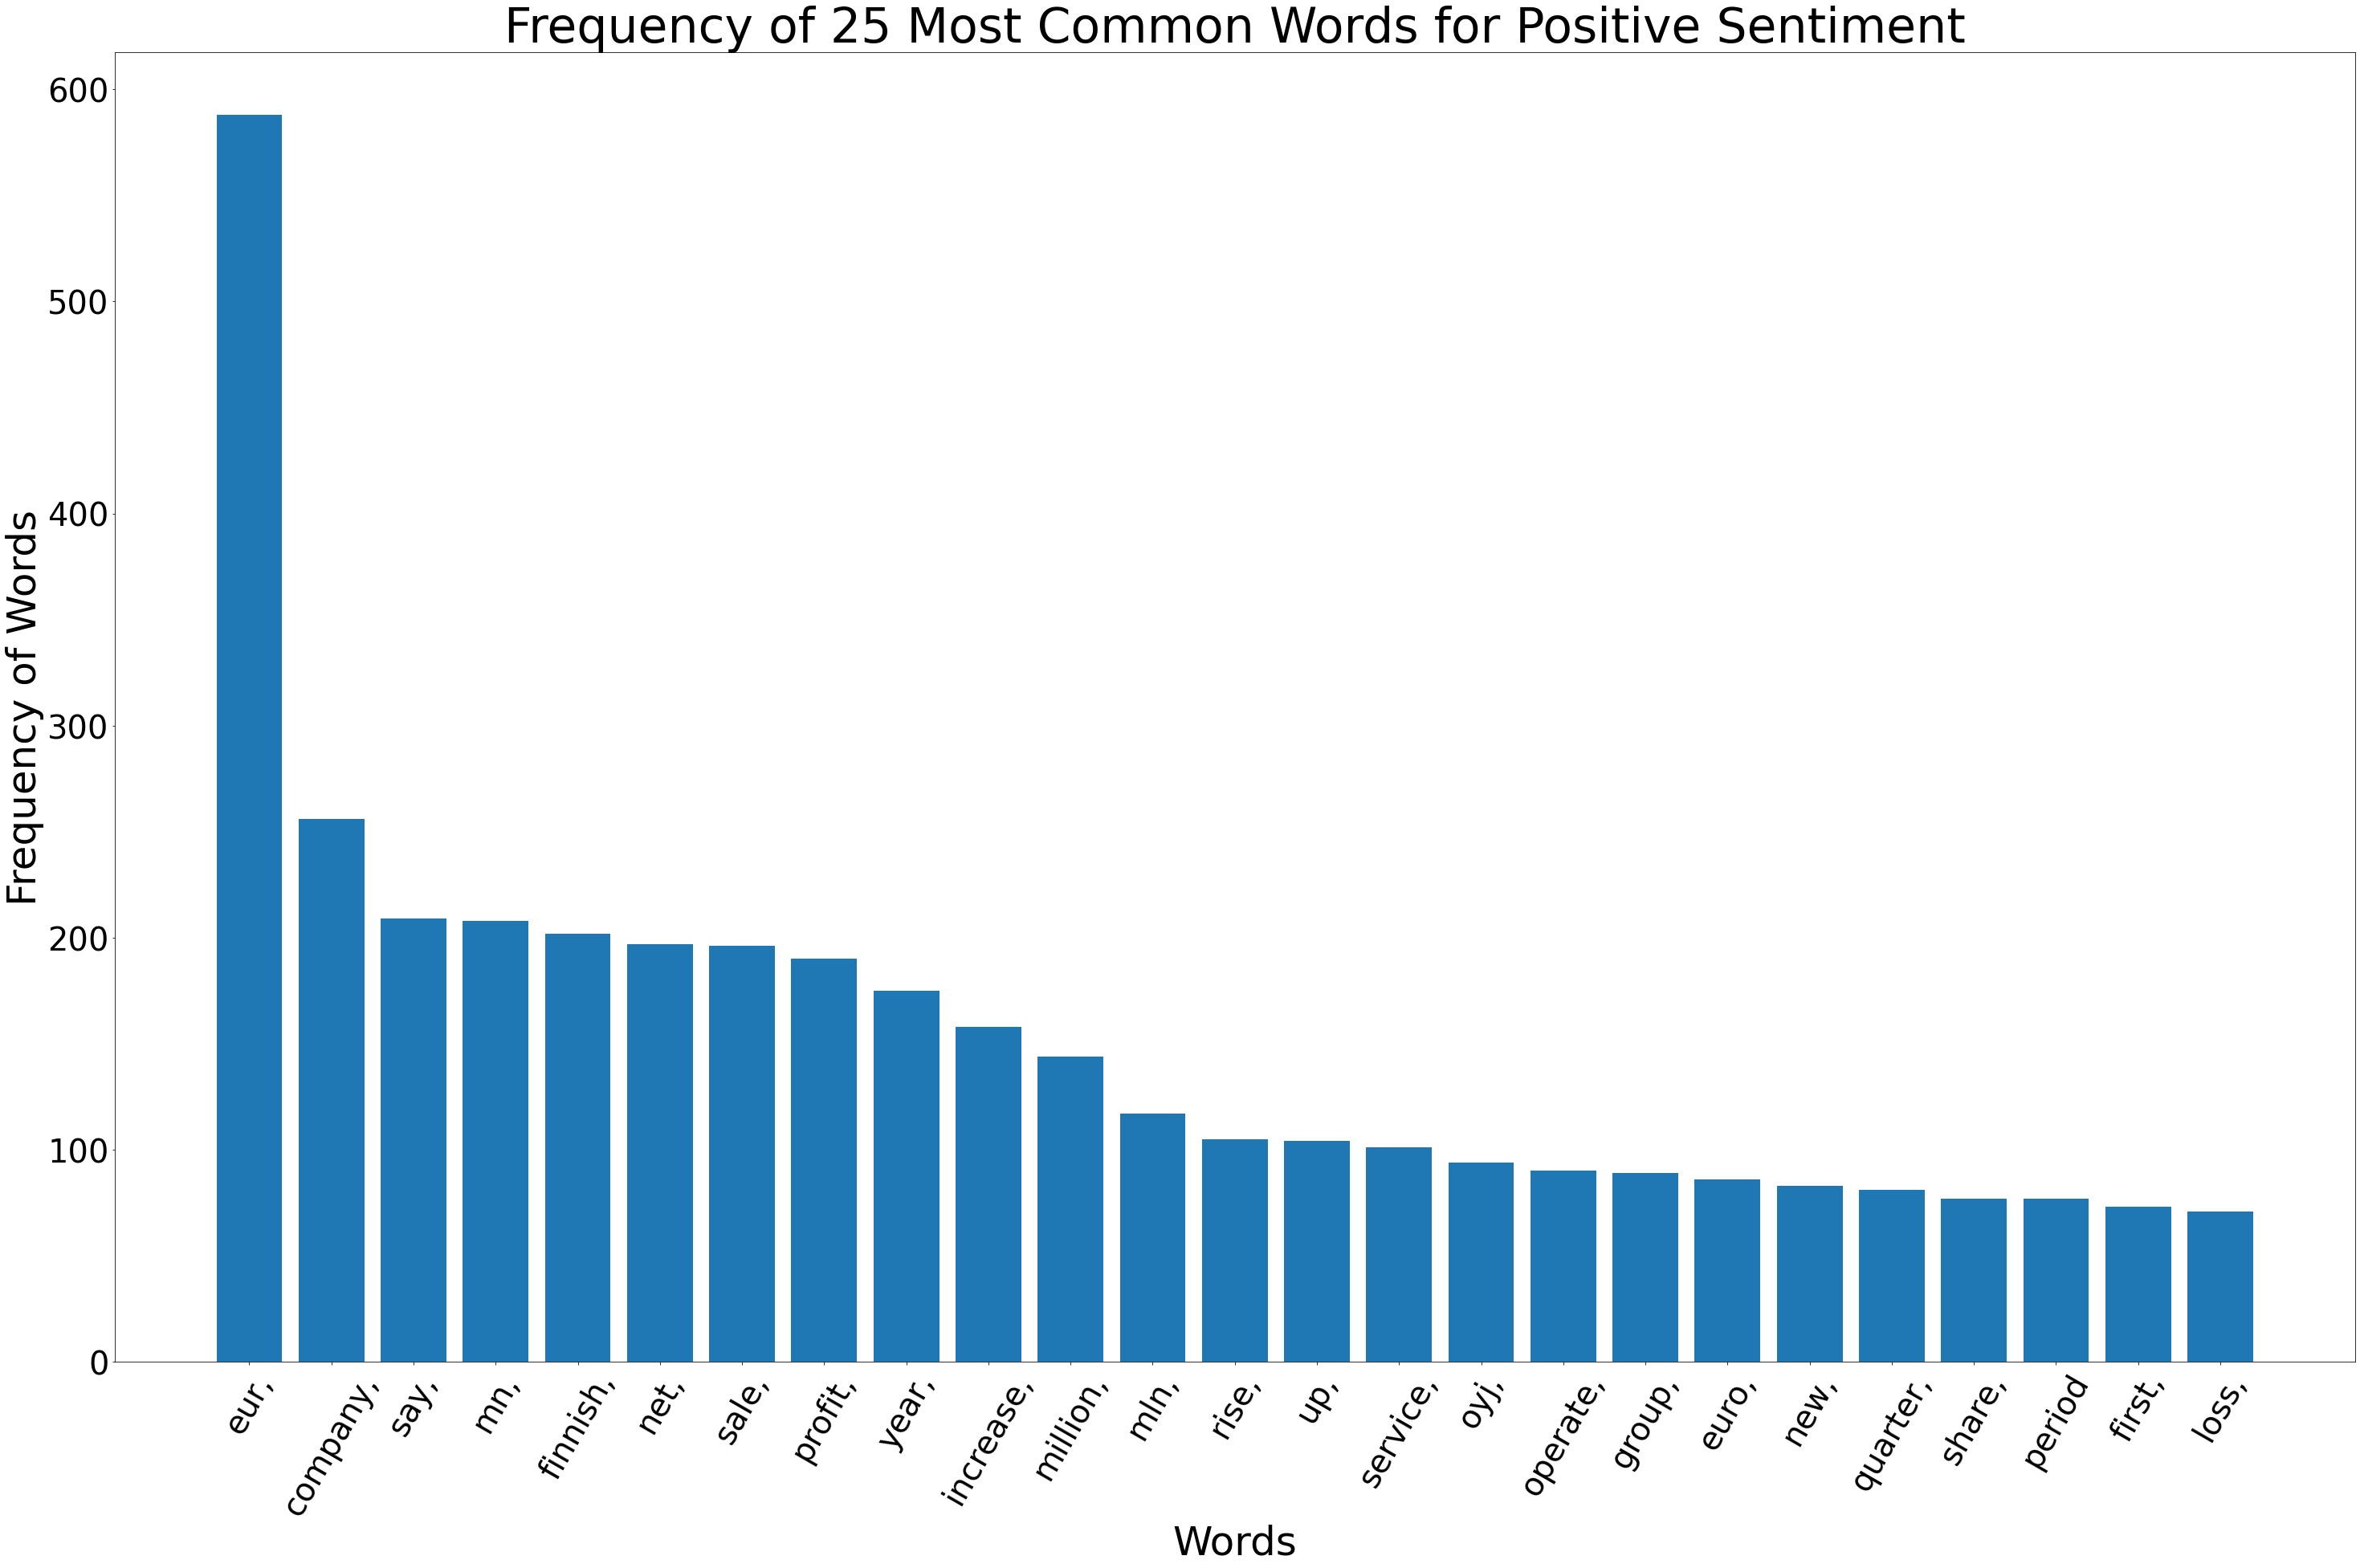

In [46]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Positive Sentiment', fontsize=60)
plt.show()

## Latent Dirichlet Allocation (LDA) Topic Modeling

In [49]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df['lemm_text'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix.head(2)

,ab,ac,accord,account,acquire,acquisition,activity,add,addition,adp,...,whole,win,work,world,worth,would,www,year,yesterday,yit
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [50]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
year quarter accord first early report expect fall medium second
Topic 1:
market percent pct paper brand grow share march remain add
Topic 2:
mln euro order area would say one company cost annual
Topic 3:
eur sale net million profit period loss compare increase year
Topic 4:
eur mn profit operate employee period corresponding up rise non
Topic 5:
company group corporation start oy two sell design plc facility
Topic 6:
finnish say oyj today bank company helsinki hel january omx
Topic 7:
service finland company business new product include also base system
Topic 8:
share company per capital board director number plan issue right
Topic 9:
total result investment value not down company financial up operation


#### Proposed Topics: <br>

**Topic 0:** Quarter comparison <br>
**Topic 1:** Brand market share growth <br>
**Topic 2:** Market growth <br>
**Topic 3:** Net profit, year comparison <br>
**Topic 4:** Employee operations <br>
**Topic 5:** New facility design <br>
**Topic 6:** Finnish stock price <br>
**Topic 7:** New products and services <br>
**Topic 8:** Capital planning <br>
**Topic 9:** Company financials up <br>

> The above are interpretations of the topics proposed by the LDA model

### TF-IDF Non-Negative Matrix Factorization (NMF)

In [63]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemm_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,ab,ac,accord,account,acquire,acquisition,activity,add,addition,adp,...,whole,win,work,world,worth,would,www,year,yesterday,yit
0,0.0,0.0,0.318581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.382216,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.42389,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.228965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.172009,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
4842,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
4843,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
4844,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0


In [68]:
nmf = NMF(n_components=10, random_state=0, alpha_H=.1, max_iter=100000, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
mn eur profit operate period total corresponding compare loss rise
Topic 1:
service new also business include market customer product mobile solution
Topic 2:
million eur euro profit usd percent net revenue value loss
Topic 3:
share per capital earning eur right eps voting number option
Topic 4:
mln euro profit net oyj first period pct quarter post
Topic 5:
sale net increase expect period eur decrease month quarter group
Topic 6:
company accord not investment finnish would one result employee production
Topic 7:
say finnish oyj hel today group maker usd omx helsinki
Topic 8:
year quarter early last percent market end expect second first
Topic 9:
finland develop headquarter helsinki group contract plant country employee base


/Users/kevinkwasnik/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 100000 reached. Increase it to improve convergence.
  warnings.warn(


#### Proposed Topics: <br>

**Topic 0:** Profit by period comparison <br>
**Topic 1:** Percent revunue loss (euro|usd) <br>
**Topic 2:** Percent market loss <br>
**Topic 3:** Earnings per share <br>
**Topic 4:** First period earning <br>
**Topic 5:** Net sales increase <br>
**Topic 6:** Employee production <br>
**Topic 7:** Finnish stock price <br>
**Topic 8:** Fiscal Quarters <br>
**Topic 9:** Site development <br>

> The above are interpretations of the topics proposed by the NMF model